In [1]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint
import pywt

import os
import struct
import matplotlib
from scipy import signal
import scipy.fftpack
import numpy as np
import sys
import pymongo
import json

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

In [3]:
patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [4]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [5]:
p1 = os.listdir("v1.2.0/eval")
print(p1)
print(os.path.isdir(p1[0]))
print(os.path.isfile(p1[1]))
pathString = ("/"+str(p1[0]))
print(pathString)
patientDict = {}
fileNames = []
maxFileSize = 0 
maxFileName = ""
for root,dirs,files in os.walk("v1.2.0"):
    #print ("root: ",root)
    #print("\tdirs: ",dirs)
    #print("\t\t",str(files))
        
    if len(files)>0:
        for file in files:
            fileNames.append(str(root)+"/"+str(file))
            if os.path.getsize((str(root)+"/"+file)) > maxFileSize:
                maxFileSize = os.path.getsize((str(root)+"/"+file))
                maxFileName = (str(root)+"/"+file)
            else:
                continue
            
            
        #print ("\t\tFile: "+files[3])
        
print (maxFileName," : ",maxFileSize)
print (os.path.splitext(maxFileName))
print (os.path.split(maxFileName))
print (os.path.splitext(os.path.split(maxFileName)[1]))
print (fileName(maxFileName))
print (fileExt(maxFileName))

['03_tcp_ar_a', '02_tcp_le', '.DS_Store', '01_tcp_ar']
False
False
/03_tcp_ar_a
v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001.edf  :  67899648
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001', '.edf')
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17', '00001278_s002_t001.edf')
('00001278_s002_t001', '.edf')
00001278_s002_t001
.edf


In [6]:
patientDbPrint = patients.find({})
sessionsDb = sessions.find({})
sessionList = []
for session in sessionsDb:
    if len(session.keys())>4:
        sessionList.append(session)
    #print(session)
    
reportText1 = sessionList[0]['reportText']

reportTextString = " ".join(reportText1)

#print(reportTextString)

reportTextStringList = reportTextString.split(" ")

fDist = nltk.FreqDist(reportTextStringList)
print(fDist.items())
#print(reportTextStringList)

'''for x in reportText1:
    print("\t"+x)
    print("\n")
    

for patient in patientDbPrint:
    print(patient)
'''

dict_items([('\n', 10), ('CLINICAL', 1), ('HISTORY:', 1), ('69', 1), ('year', 1), ('old', 1), ('female', 1), ('with', 3), ('refractory', 1), ('status', 2), ('epilepticus', 1), ('following', 1), ('craniotomy', 1), ('for', 2), ('subdural', 1), ('hematoma.\n', 1), ('MEDICATIONS:', 1), ('Keppra,', 1), ('Dilantin\n', 1), ('INTRODUCTION:', 1), ('Continuous', 1), ('digital', 1), ('video', 1), ('EEG', 4), ('was', 2), ('performed', 1), ('at', 2), ('bedside', 1), ('using', 1), ('standard', 1), ('10-20', 1), ('system', 1), ('of', 1), ('electrode', 2), ('placement', 1), ('1', 2), ('channel', 1), ('EKG.', 1), ('This', 2), ('recording', 1), ('begins', 1), ('just', 1), ('after', 1), ('the', 8), ('patient', 2), ('has', 1), ('been', 1), ('treated', 1), ('on', 1), ('6/28', 1), ('epilepticus.\n', 1), ('DESCRIPTION', 1), ('OF', 1), ('THE', 1), ('RECORD:', 1), ('The', 3), ('background', 1), ('demonstrates', 2), ('a', 1), ('very', 1), ('irritative', 1), ('pattern', 1), ('repetitive', 1), ('sharp', 1), ('wav

'for x in reportText1:\n    print("\t"+x)\n    print("\n")\n    \n\nfor patient in patientDbPrint:\n    print(patient)\n'

In [7]:
#print(sessionFound.count())
#print(sessionFound)
allSessions = sessions.find({})
print(allSessions.count())
#populate words
wordList = []

report1 = sessions.find_one({})['reportText']
for x in report1:
    #print(x)
    for y in (x.split(' ')):
        wordList.append(y)

newList = []
finalList =[]
x = 1 
for session in allSessions:  
    for line in session['reportText']:
        for word in line.split(' '):
            newList.append(word)
    newList = list(set(newList)&set(wordList))
    
print(newList)        


            

    

239
['\n', 'old', 'status', 'region.', 'occipital', 'By', 'noted.\n', 'very', 'seizure', 'discharges', 'repetitive', 'subdural', 'activity', '10-20', 'record,', 'standard', 'At', 'Prominent', 'discontinuous.', 'later', 'treated', 'Dilantin\n', 'sharp', 'epilepticus', 'Intermittently', 'has', 'the', 'a.m.\n', 'Abnormal', 'begins', 'at', 'The', 'changes', 'Single', 'Sustained', 'lost,', 'for', 'due', 'using', 'minute.', 'demonstrates', '06:37', 'craniotomy', 'HISTORY:', 'region.\n', 'intermittently', 'been', 'temporal', 'and', 'right', 'Continuous', 'bedside', 'duration', 'MEDICATIONS:', '1', 'pattern.\n', 'DESCRIPTION', 'posterior', 'recording', 'to:\n', 'irritative', 'seizures', 'bursts', 'background', 'not', 'term', '90', 'a', 'Seizure', 'a.m.,', 'CLINICAL', 'regions,', 'female', 'is', 'by', 'following', 'electrode', 'system', 'on', 'activity.', 'record', 'integrity', 'EKG.', 'epileptiform', 'fast', 'performed', 'just', 'video', 'THE', '11:18', 'brief', 'with', 'digital', 'characteriz

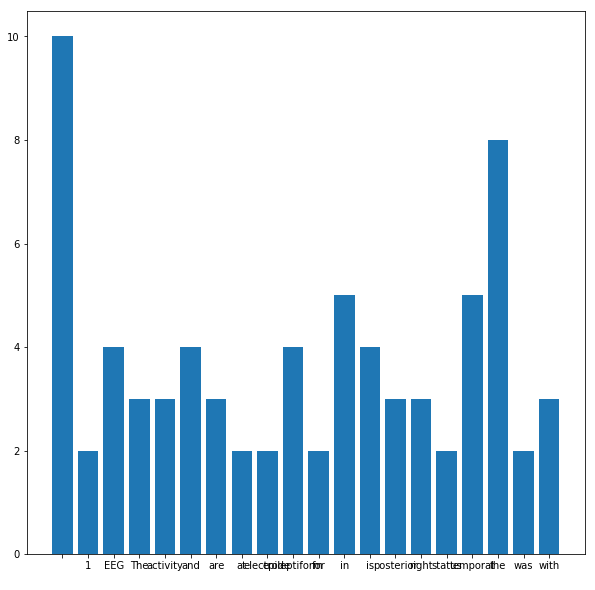

In [8]:
#fDist.most_common(30)
mostCommon = fDist.most_common(20)
xAxisVals = []
yAxisVals = []

plt.figure(figsize=(10,10))
for x in mostCommon:
    xAxisVals.append(x[0])
    yAxisVals.append(x[1])
plt.bar(xAxisVals,yAxisVals)
plt.show()

In [9]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time  of record desired in seconds
        ##########This might be easier to do within original edf class
        Need to change to accomdate FLOATING POINTS !!!!!!!!!!!
        '''
        toReturn = []
        startByte = float(start) * self.sampleRate * 2
        print("TYPE START: ",type(start))
        print("channel.channelData Sample Rate: ",type(self.sampleRate))
        print("Start: ",start)
        print("START BYTE FROM CHANNEL DATA: ",startByte," Start: ",start," SampleRate: ",self.sampleRate)
        seekLocation = int(self.channelIndex + int(startByte))  #need to fix this --------------
        print('Seek Location: ',seekLocation)
        numberOfBytes = int(self.sampleRate) * float(duration) #* 2
        try:
            numberOfBytes = int(numberOfBytes)
        except:
            return "ERROR in numberOfBytes"
        
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            try:
                value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
                value = value*sensitivity    #Changed this from np.array(value)*sensitivity
                value -= channelNumber*20*sensitivity
            except:
                value = 'E'
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return float(self.physMin)
    
    def getPhysMax(self):
        return float(self.physMax)
    
    def getDigMin(self):
        return float(self.digMin)
    
    def getDigMax(self):
        return float(self.digMax)
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength

In [10]:
#Need to add functions to this class to return the data containing specified feature

class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
        
    def returnChannelObjects(self):
        return self.channels
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = float(self.edfRawData.read(8))
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        
        self.channelObjects = []
        self.sampleRate = int(self.channels['sampleRate'][0])
        channelDataStart = self.headerBytes
        
    
        #This loop creates and adds channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords     #*2
            channelIndex = channelDataStart
            channelDataStart +=byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelDataStart,byteLength))  #Changed this channelIndex to channelDataStart
    
    
        self.channelSampleRates = channelValues['sampleRate'] 
        self.channelDigMax = channelValues['digMax']
        self.channelDigMin = channelValues['digMin']
        self.channelPhysMax = channelValues['physMax']
        self.channelPhysMin = channelValues['physMin']
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataDictionary(self,start,duration):
        sampleData = {}
        j = 0
        #Returns dictionary with key being channel label, values being a dict [data,sampleRate,digMax,digMin,physMax,physMin]
        for x in self.channelObjects:
            sampleData[x.getLabel()]={'data':x.channelData(start,duration),'sampleRate':x.getSampleRate(),
                                     'digMax':x.getDigMax(),'digMin':x.getDigMin(),'physMin':x.getPhysMin(),
                                     'physMax':x.getPhysMax()}
            print(x)
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=x.allChannelData()
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def headerBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def duration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def sampleRate(self):
        return int(self.sampleRate)

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [12]:
# must change function to look for existing tse data and append the new record to the existing array.
# This is found in the parsePatient function.
def parseTse(filePath):
    try:
        with open(str(filePath),'r') as tseFileData:
            tseData = [line.rstrip('\n') for line in tseFileData]
        #print("Entry (Parse Fuction: ): ",tseData)
        tseEntryList = []
        for entry in tseData:
            entryList = entry.split(" ")
            #print("TSE DATA ENTRY (parse function) : ",entryList)
            if len(entryList) == 4:
                splitFile = filePath.split('/')
                currentFile = splitFile[5] #changed from 5 to 4
                currentSessionNumber = splitFile[4].split('_')[0]
                currentFileSplit = currentFile.split('_')
                currentT = currentFileSplit[2].split(".")
                currentT = currentT[0]
                tseEntry = {'currentT':currentT,'startTime':entryList[0],'endTime':entryList[1],
                               'eventLabel':entryList[2],'probability':entryList[3]}
                tseEntryList.append(tseEntry)
            else:
                pass
                #print("LEN NOT 4: ",entryList)
        return(tseEntryList)
    except Exception as exc:
        print("Exception: ",exc)
        print("Found an error with tseFile()")
        
def parseLbl(filePath):
    return "Not done yet"

In [13]:
def addFile(filepath):
    splitFile = filepath.split('/')
    if len(splitFile)<6:
        pass
        #print("File path too short")
    else:
        patientId = splitFile[3]
        currentFile = splitFile[5] #changed from 5 to 4
        currentSessionNumber = splitFile[4].split('_')[0]
        currentFileSplit = currentFile.split('_')
        currentFileExt = str(fileExt(currentFile))
        sessionNumber = currentFileSplit[0] #Changed from 1 to 0
        sessionId = str(patientId)+str(currentSessionNumber)
        #print("\tFile Path: ",filepath)
        #print("\t\tCurrentFile: ",currentFileSplit)
        #print("\t\tCurrentFileExt: ",currentFileExt)
        #print("\t\tSessionId: ",sessionId)
        dbSession = sessions.find_one({"sessionId":sessionId})
        
        if dbSession == None:
            sessions.insert_one({"sessionId":sessionId,"patientId":patientId})
            #print("Found a new session")
        else:
            pass
            #print("Found this session\n")  
        if currentFileExt == ".txt":
            try:
                with open(str(files),'r') as reportFile:
                    rText = reportFile.readlines()  
                try:
                    sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":rText}})
                except:
                    pass
                    #print("Could not add report text")     
            except UnicodeDecodeError:
                sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":"Unopenable"}})
        elif currentFileExt  == ".edf":
            try:
                updateEdf = dbSession['edfList']
                updateEdf.append(filepath)
                #edfFileData = edfData(1)
                #edfFileData.loadFile(filePath)
                #edfFileData.parseEdf()
                #print("EDF DATA: ",edfFileData.channelSampleRates)
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":updateEdf}})    
                #ADD EDF INFO EX SAMPLE RATE AND OTHER INFO
                
                #This is new~~~~~~~~~~~~~~~~---------------!!!!!!!!!!!!!!!!!!!!!@#$%@#^$%$#%@$#%#$@%@%^%$^#
                #sessions.update_one({"sessionId":sessionId},{"$set":{"sampleRates":edfFileData.channelSampleRates}})
                
                
            except:
                #print ("No edf") 
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":[filepath]}})
        elif currentFileExt == ".lbl":
            try:
                updateLbl = dbSession['lblList']
                updateLbl.append(filepath)
                #print("\n\nUPDATING LABL LIST-------------")
                #print(updateLbl)
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":updateLbl}})
            except:
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":[filepath]}})
                
    #TSE DATA ERROR IN FIRST ENTRY BECAUSE dbSessionTSEDATA DOESNT EXIST
    ###### Must change function to append to existing tse data entry, look for existing
    ###### Then append the new data entries.
    ##### Changed lne 'updateTseData.append(tseEntry)' to updateTseData += tseEntry in for loop
        elif currentFileExt == ".tse":
            try:
                updateTse = dbSession['tseList']
                updateTse.append(filepath)
                updateTseData = dbSession['tseData']
                #print("updateTseData from find: ",updateTseData)
                tseEntry = parseTse(files)
                updateTseData = updateTseData + tseEntry
                '''
                for entry in tseEntry:    
                    updateTseData += entry
                '''
                #print("After Append--------->")
                #print(updateTseData)
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":updateTse}})
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":updateTseData}})
            
            except Exception as exc:
                #print("TSE EXCEPTION ENCOUNTERED")
                #print("EXC: ",exc)
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":[filepath]}})
                
                tseEntry = parseTse(files)
    
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":tseEntry}})
            

In [14]:
#print(fileNames[0:30])
testDb.patients.delete_many({})
testDb.sessions.delete_many({})
testDb.reports.delete_many({})

for files in fileNames:
    addFile(files)
    

In [12]:
#Write function to take edf file path and return EEG data. 
        #Add optional parameters to input tse data and return only that EEG data. 
#Return data samples with certain feature and specified time before and after

#https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
def ensure_dir(file_path):
    directory =  file_path# os.path.dirname(file_path)
    print("DIRECTORY: ",directory)
    if not os.path.exists(directory):
        os.makedirs(directory)

def loadFeatureData(filePath):
    edfData = json.load(open(filePath,'r'))
    return edfData
    
    
    
def returnSampleRateEdf(edfFilePath):
    edfFile = edfData(1)
    edfFile.loadFile(edfFilePath)
    edfFile.parseEdf()
    return edfFile.sampleRate
    
        
    # NEED TO ADD EDF FILE PATH and channel information to this to make it usefull!!!!!!!!!!!!!!!!!!!!!!
def returnFeatureData(featureSearch,timeBefore=10,timeAfter=10):
    records = testDb.sessions.find({'tseData.eventLabel':featureSearch})
    recordList = []
    fileNameString = (str(featureSearch)+'_'+str(timeBefore)+'_'+str(timeAfter))
    print("FileNameString: "+fileNameString)
    iterations = 0
    with open(fileNameString,'w') as featureDataFile:
        featureDataFile.write(str(featureSearch)+'\n')
        directoryName = str(featureSearch+"Directory")
        ensure_dir(directoryName)
        for x in records:
            iterations+=1
            if iterations == 4:
                break
            #print(x['sessionId'])
            recordList.append(x)
            for tse in x['tseData']:
                if tse['eventLabel'] == featureSearch:
                    print(tse)
                    for edf in x['edfList']:
                        if (str(tse['currentT'])+'.edf') in edf.split('_'):  #This is messy, clean it up
                            startTime = float(tse['startTime'])
                            endTime = float(tse['endTime'])
                            duration = endTime-startTime
                            sampleRate = returnSampleRateEdf(edf)
                            #print("In if statement should be printing sample rate right after this.")
                            #print("SAMPLE RATE FROM EDF: ",sampleRate)
                            #print("Start Time from TSE: ",startTime)
                            #print("End Time from TSE: ",endTime)
                            #print("Duration: ",duration)
                            
                            #print(edf)
                            txtFileName = (str(edf.split('/')[-1].split('.')[0])+'.txt')
                            #print("EDF SPLIT: ",edf)
                            edfFile = edfData(1)
                            edfFile.loadFile(edf)
                            edfFile.parseEdf()
                            edfDataText = edfFile.dataDictionary(startTime,endTime)
                            #print("Should be writing")
                            edfFilePathWrite = str(directoryName)+"/"+str(txtFileName)
                            with open(edfFilePathWrite,'w') as featureDataFile:
                                featureDataFile.write(json.dumps(edfDataText))
                            #for key in edfDataText:
                            #    print(key)
                            #    print("EDF VALUE: ",edfDataText[key][0:100])
                            #featureDataFile.write()               
    print(len(recordList))
     
returnFeatureData('fnsz')      #This creates a directory with txt files containing all of the fatured data
featureFiles = os.listdir('fnszDirectory')
print(featureFiles)

sampleTxtFile = 'fnszDirectory/'+str(featureFiles[0])

testDataFile = loadFeatureData(sampleTxtFile)


#uniquePatients = testDb.sessions.distinct('patientId')
#print(len(uniquePatients))


uniqueTseOnly = testDb.sessions.distinct('tseData.eventLabel')
print(uniqueTseOnly)

#abszRecords = testDb.sessions.find({'tseData.eventLabel':'absz'})
#print(abszRecords)
#print(abszRecords['edfList'])
#pt1 = testDb.sessions.find_one({'patientId':'00005479'})
#for x in abszRecords:
#    print(x['edfList'][0])
#    print(x['tseData'])

#print(pt1)
#print(pt1['tseData'])
'''for entry in pt1['tseData']:
    print('Entry: ',entry)
    for i in entry:
        print(i)
'''

FileNameString: fnsz_10_10
DIRECTORY:  fnszDirectory
{'currentT': 't002', 'startTime': '62.9323', 'endTime': '153.2431', 'eventLabel': 'fnsz', 'probability': '1.0000'}
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  62.9323
START BYTE FROM CHANNEL DATA:  50345.84  Start:  62.9323  SampleRate:  400
Seek Location:  220793
Label: b'EEG FP1-REF     '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 170448
byteLength: 162000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  62.9323
START BYTE FROM CHANNEL DATA:  50345.84  Start:  62.9323  SampleRate:  400
Seek Location:  382793
Label: b'EEG FP2-REF     '
S

Start:  62.9323
START BYTE FROM CHANNEL DATA:  50345.84  Start:  62.9323  SampleRate:  400
Seek Location:  4918793
Label: b'EEG 30-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 4868448
byteLength: 162000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  62.9323
START BYTE FROM CHANNEL DATA:  50345.84  Start:  62.9323  SampleRate:  400
Seek Location:  5080793
Label: b'EEG 31-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz 

Start:  10.0067
START BYTE FROM CHANNEL DATA:  8005.360000000001  Start:  10.0067  SampleRate:  400
Seek Location:  3868453
Label: b'EEG 30-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 3860448
byteLength: 128400
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  10.0067
START BYTE FROM CHANNEL DATA:  8005.360000000001  Start:  10.0067  SampleRate:  400
Seek Location:  3996853
Label: b'EEG 31-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilte

TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  87.7643
START BYTE FROM CHANNEL DATA:  70211.44  Start:  87.7643  SampleRate:  400
Seek Location:  468659
Label: b'EEG F3-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 398448
byteLength: 130000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  87.7643
START BYTE FROM CHANNEL DATA:  70211.44  Start:  87.7643  SampleRate:  400
Seek Location:  598659
Label: b'EEG F4-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29

START BYTE FROM CHANNEL DATA:  62412.72  Start:  78.0159  SampleRate:  400
Seek Location:  4320860
Label: b'EEG FZ-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 4258448
byteLength: 250000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  78.0159
START BYTE FROM CHANNEL DATA:  62412.72  Start:  78.0159  SampleRate:  400
Seek Location:  4570860
Label: b'EEG CZ-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0

TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  484.5016
START BYTE FROM CHANNEL DATA:  387601.27999999997  Start:  484.5016  SampleRate:  400
Seek Location:  4146049
Label: b'EEG T5-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 3758448
byteLength: 250000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  484.5016
START BYTE FROM CHANNEL DATA:  387601.27999999997  Start:  484.5016  SampleRate:  400
Seek Location:  4396049
Label: b'EEG T6-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin

TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  56.9618
START BYTE FROM CHANNEL DATA:  45569.439999999995  Start:  56.9618  SampleRate:  400
Seek Location:  462017
Label: b'EEG F4-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 416448
byteLength: 102000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  56.9618
START BYTE FROM CHANNEL DATA:  45569.439999999995  Start:  56.9618  SampleRate:  400
Seek Location:  564017
Label: b'EEG C3-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29

channel.channelData Sample Rate:  <class 'int'>
Start:  104.9363
START BYTE FROM CHANNEL DATA:  83949.04000000001  Start:  104.9363  SampleRate:  400
Seek Location:  2642397
Label: b'EEG T5-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 2558448
byteLength: 170000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  104.9363
START BYTE FROM CHANNEL DATA:  83949.04000000001  Start:  104.9363  SampleRate:  400
Seek Location:  2812397
Label: b'EEG T6-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.

START BYTE FROM CHANNEL DATA:  81242.0  Start:  101.5525  SampleRate:  400
Seek Location:  5189690
Label: b'EEG 30-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 5108448
byteLength: 170000
TYPE START:  <class 'float'>
channel.channelData Sample Rate:  <class 'int'>
Start:  101.5525
START BYTE FROM CHANNEL DATA:  81242.0  Start:  101.5525  SampleRate:  400
Seek Location:  5359690
Label: b'EEG 31-REF      '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.

"for entry in pt1['tseData']:\n    print('Entry: ',entry)\n    for i in entry:\n        print(i)\n"

File:  fnszDirectory/00009842_s001_t000.txt
dict_keys(["b'EEG FP1-REF     '", "b'EEG FP2-REF     '", "b'EEG F3-REF      '", "b'EEG F4-REF      '", "b'EEG C3-REF      '", "b'EEG C4-REF      '", "b'EEG P3-REF      '", "b'EEG P4-REF      '", "b'EEG O1-REF      '", "b'EEG O2-REF      '", "b'EEG F7-REF      '", "b'EEG F8-REF      '", "b'EEG T3-REF      '", "b'EEG T4-REF      '", "b'EEG T5-REF      '", "b'EEG T6-REF      '", "b'EEG A1-REF      '", "b'EEG A2-REF      '", "b'EEG FZ-REF      '", "b'EEG CZ-REF      '", "b'EEG PZ-REF      '", "b'EEG ROC-REF     '", "b'EEG LOC-REF     '", "b'EEG EKG1-REF    '", "b'EMG-REF         '", "b'EEG 26-REF      '", "b'EEG 27-REF      '", "b'EEG 28-REF      '", "b'EEG 29-REF      '", "b'EEG 30-REF      '", "b'EEG T1-REF      '", "b'EEG T2-REF      '", "b'PHOTIC-REF      '", "b'IBI             '", "b'BURSTS          '", "b'SUPPR           '"])
dict_keys(['data', 'sampleRate', 'digMax', 'digMin', 'physMin', 'physMax'])


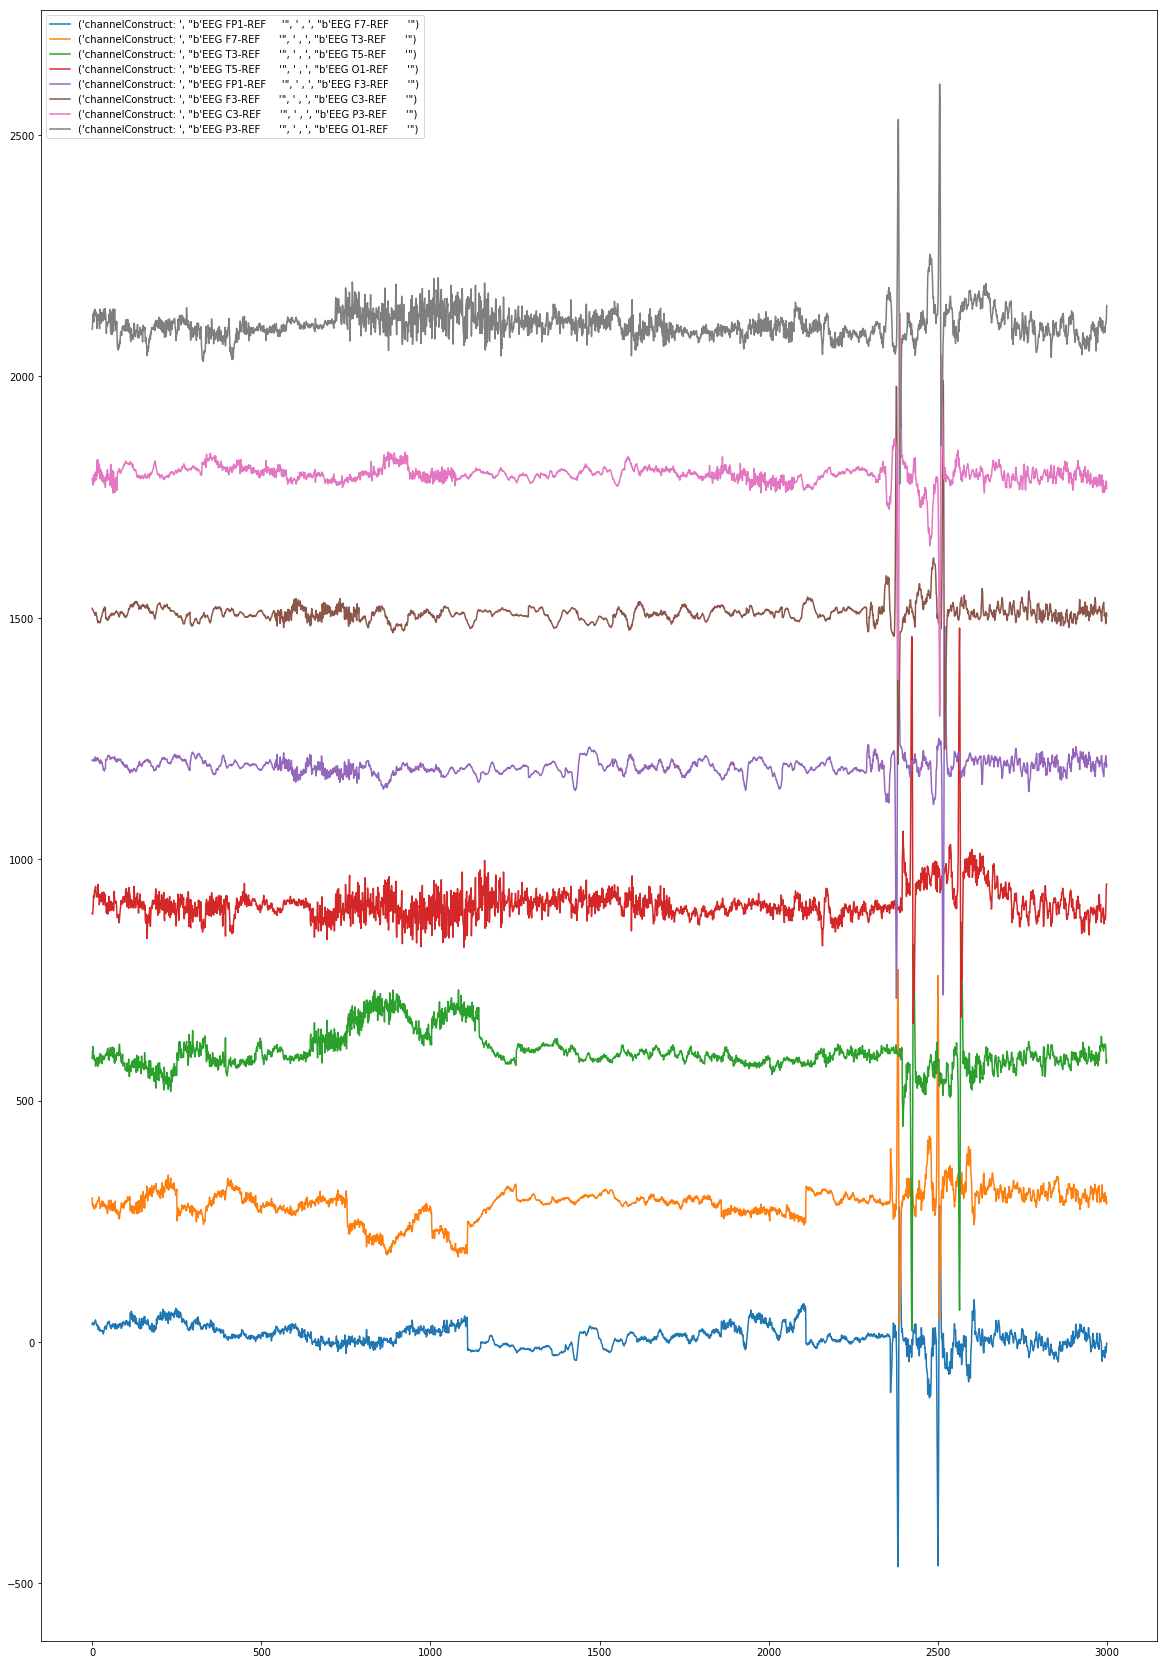

In [13]:
#featureFiles = os.listdir('fnszDirectory')
#print(featureFiles)
sampleTxtFile = 'fnszDirectory/'+str(featureFiles[0])
testDataFile = loadFeatureData(sampleTxtFile)
eegKeys = list(testDataFile.keys())
print("File: ",sampleTxtFile)
print (testDataFile.keys())
print(testDataFile[eegKeys[0]].keys())

#print(testDataFile[eegKeys[0]][0:20])
#for i,key in enumerate(eegKeys):
#    print (i,' : ',key,testDataFile[key][0:10])
    
longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8]]
plt.figure(figsize=(20,30))

def fft(time_data):
    return np.log10(np.absolute(np.fft.rfft(time_data, axis=1)[:,1:48]))

startPoint = 500
endPoint = 3500
fftData = {}
for i,channelConstruct in enumerate(longBipolarMontage):
    #print ('channelConstruct: ',channelConstruct[0],' , ',channelConstruct[1])
    #Check these t ensure that each input has the same parameters
    sampleRate1  = testDataFile[eegKeys[channelConstruct[0]]]["sampleRate"]
    digMin1 = testDataFile[eegKeys[channelConstruct[1]]]["digMin"]
    digMax1 = testDataFile[eegKeys[channelConstruct[1]]]["digMax"]
    physMin1 = testDataFile[eegKeys[channelConstruct[1]]]["physMin"]
    physMax1 = testDataFile[eegKeys[channelConstruct[1]]]["physMax"]
    sampleRate2 = testDataFile[eegKeys[channelConstruct[1]]]["sampleRate"]
    digMin2 = testDataFile[eegKeys[channelConstruct[1]]]["digMin"]
    digMax2 = testDataFile[eegKeys[channelConstruct[1]]]["digMax"]
    physMin2 = testDataFile[eegKeys[channelConstruct[1]]]["physMin"]
    physMax2 = testDataFile[eegKeys[channelConstruct[1]]]["physMax"]
    scaleRatio = physMin1/digMin1
    
    #print ("SR1: ",sampleRate1," SR2: ",sampleRate2, "DigMin: ",digMin1," physMin: ",physMin1,"Ratio: ",(physMin1/digMin1))
    channelData = np.array(testDataFile[eegKeys[channelConstruct[0]]]["data"][startPoint:endPoint]) - np.array(testDataFile[eegKeys[channelConstruct[1]]]["data"][startPoint:endPoint])
    #print("CHANNEL LENGTH: ",len(channelData))
    channelName = (str(eegKeys[channelConstruct[0]])+' , '+str(eegKeys[channelConstruct[1]]))
    #fftData[channelName] = fft(channelData)
    #fftData[channelName] = scipy.fftpack.fft(channelData)
    #print (eegKeys[channelConstruct[0]],' - ',eegKeys[channelConstruct[1]],' : ',channelData)
    #plt.plot((channelData/100+i*1000),label=('channelConstruct: ',eegKeys[channelConstruct[0]],' , ',eegKeys[channelConstruct[1]]))
    plt.plot((channelData*scaleRatio+i*300),label=('channelConstruct: ',eegKeys[channelConstruct[0]],' , ',eegKeys[channelConstruct[1]])) 
    plt.legend()

SampleRate:  250
SampleRate:  250
SampleRate:  250
SampleRate:  250
SampleRate:  250
SampleRate:  250
SampleRate:  250
SampleRate:  250
EX 2 AVERAGE VALUE:  

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


258.48
EX 2 Max:  2832
EX 2 Min:  -2118


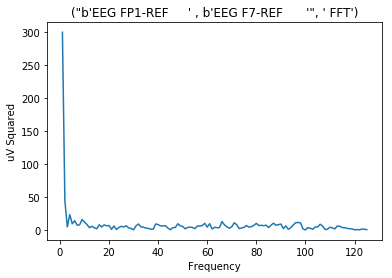

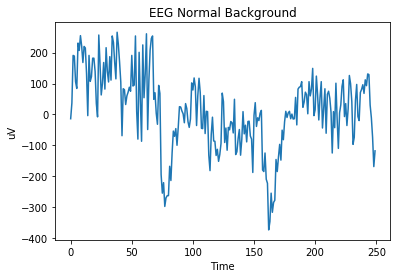

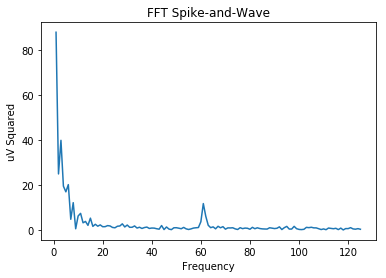

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


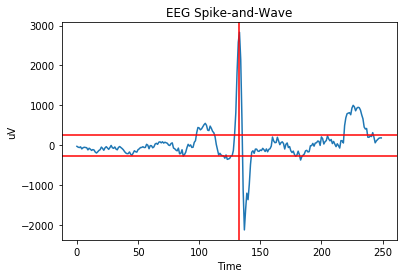

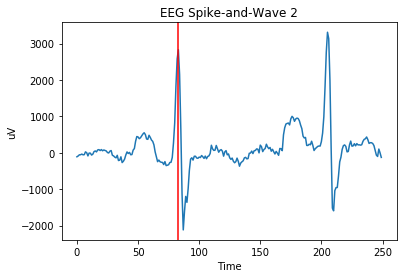

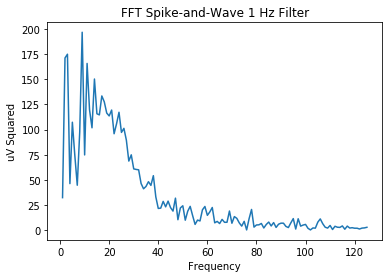

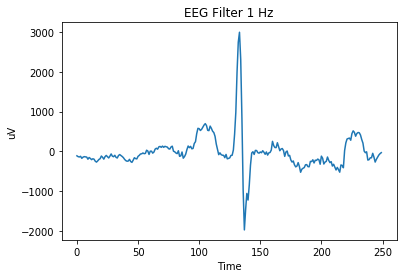

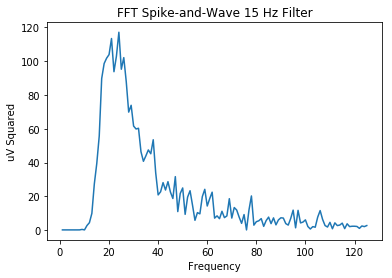

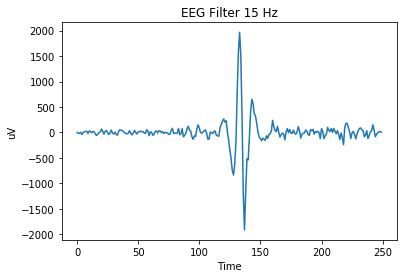

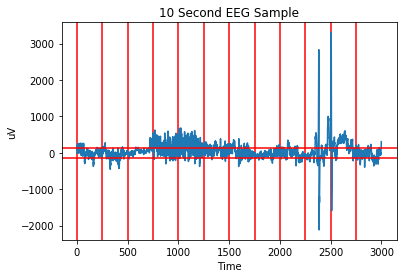

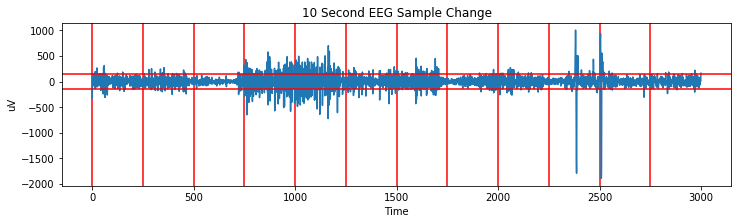

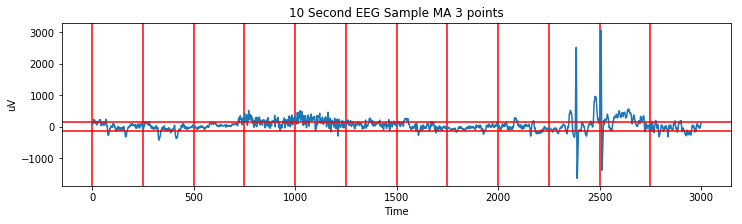

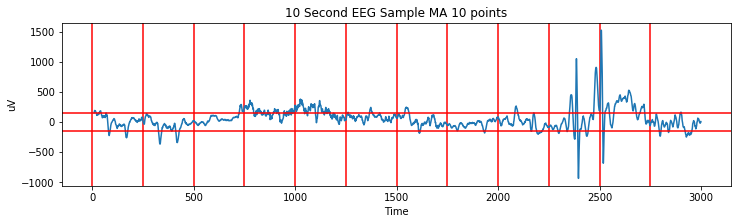

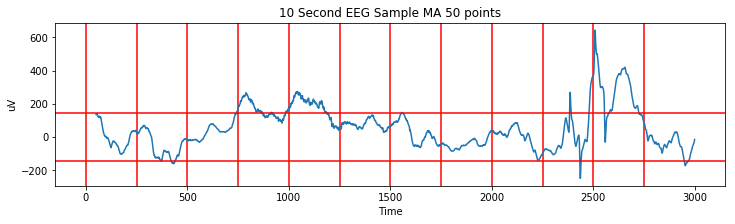

'\nhttps://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python\nN = 600\n# sample spacing\nT = 1.0 / 800.0\nx = np.linspace(0.0, N*T, N)\ny = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)\nyf = scipy.fftpack.fft(y)\nxf = np.linspace(1.0, 1.0/(2.0*T), N/2)\n\nfig, ax = plt.subplots()\nax.plot(xf, 2.0/N * np.abs(yf[:N//2]))\nplt.show()\n'

In [14]:
sampleTxtFile = 'fnszDirectory/'+str(featureFiles[0])
testDataFile = loadFeatureData(sampleTxtFile)

#https://stackoverflow.com/questions/39032325/python-high-pass-filter

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def getChangeArray(inputArray):
    newArray =[]
    for i in range(len(inputArray)):
        if i==0:
            pass
        newArray.append(inputArray[i]-inputArray[i-1])
    return newArray

def movingAverage(inputArray,avgNum):
    newArray = []
    for i in range(len(inputArray)):
        if i<avgNum:
            pass
        newArray.append(np.average(inputArray[i-(avgNum):i]))
    return newArray
            
        

def returnVariation(eegData,width,sampleRate):
    #Looks for greatest change over the specified width in the signal
    #width is samples to 
    v1 = eegData[0]
    totalChange = 0 
    maxChange = 0
    maxIndex = 0
    dataLength = len(eegData)
    for i in range(dataLength-width):
        currentChange = 0
        for j in range(width-1):
            currentChange += eegData[j+i]-eegData[j+i+1]
             
        if abs(currentChange) > abs(maxChange):
            maxChange = currentChange
            maxIndex = i
        #print(currentChange)
        currentChange = 0
        
    msTime = maxIndex/sampleRate
    #print("Max Change: ",maxChange," Max Index: ",maxIndex," Max Time: ",msTime)
    return [maxChange,maxIndex,msTime]
        
    

fftData = {}
#Need to change EEG data to return actual values. 
# Find FFT for each 1 second segment of each channel.
fftStartPoint = 0
fftEndPoint = 6000
#Calculate FFT for each second of each channel.
for i,channelConstruct in enumerate(longBipolarMontage):
    #print ('channelConstruct: ',channelConstruct[0],' , ',channelConstruct[1])
    digMax = testDataFile[eegKeys[channelConstruct[0]]]["digMax"]
    physMax = testDataFile[eegKeys[channelConstruct[0]]]["physMax"]
    scaleRatio = physMax/digMax
    channelData = scaleRatio * np.array(testDataFile[eegKeys[channelConstruct[0]]]["data"][fftStartPoint:fftEndPoint]) - np.array(testDataFile[eegKeys[channelConstruct[1]]]["data"][fftStartPoint:fftEndPoint])
    samplesInChannelData = len(channelData)
    sampleRate = testDataFile[eegKeys[channelConstruct[0]]]["sampleRate"]
    print("SampleRate: ",sampleRate)
    durationOfSample = samplesInChannelData/sampleRate
    channelName = (str(eegKeys[channelConstruct[0]])+' , '+str(eegKeys[channelConstruct[1]]))
    for segment in range(int(durationOfSample)):
        start = segment*sampleRate
        end = start+sampleRate
        #print("Start: ",start," End: ",end,' SampleData: ', channelData[start:start+10])
        if channelName in fftData.keys():
            fftData[channelName].append(scipy.fftpack.fft(channelData[start:end])) 
        else:
            fftData[channelName] = [(scipy.fftpack.fft(channelData[start:end]))]
    
    #fftData[channelName] = scipy.fftpack.fft(channelData)
#print(fftData.keys())

eegChannelData = np.array(testDataFile[eegKeys[channelConstruct[0]]]["data"][startPoint:endPoint]) - np.array(testDataFile[eegKeys[channelConstruct[1]]]["data"][startPoint:endPoint])
eegExample = eegChannelData[0:250]

eegExample2 = eegChannelData[2250:2500] #Contains spike
spikeSample2 = eegChannelData[2300:2550]
spikeMaxChange = returnVariation(eegExample2,5,sampleRate)
spikeMaxChange2 = returnVariation(spikeSample2,5,sampleRate)
normalBackground = eegChannelData[0:250]
eegExample10Seconds = eegChannelData[0:3000]
eegExample10SecondsChange = getChangeArray(eegExample10Seconds)
eegExample10SecondsMA10 = movingAverage(eegExample10Seconds,10)
eegExample10SecondsMA3 = movingAverage(eegExample10Seconds,3)
eegExample10SecondsMA50 = movingAverage(eegExample10Seconds,50)


channelList = list(fftData.keys())
fftExampleChannel = channelList[0]
fftExample = (fftData[fftExampleChannel][0])
#contains spike-and-wave
fftExample2 = (fftData[fftExampleChannel][8])
fftExampleF1 = scipy.fftpack.fft(butter_highpass_filter(eegExample2,1,sampleRate))
fftExampleF2 = scipy.fftpack.fft(butter_highpass_filter(eegExample2,15,sampleRate))
fftExample3 = (fftData[fftExampleChannel][9]) 




T =  1.0/len(fftExample)
N = len(fftExample)

#Start,Stop,Number of samples!!!
xf = np.linspace(1,1.0/(2.0*T), N/2)


averageValue2 = np.mean(np.absolute(eegExample2))
print("EX 2 AVERAGE VALUE: ",averageValue2)
print("EX 2 Max: ",max(eegExample2))
print("EX 2 Min: ",min(eegExample2))

plt.plot(xf, 2.0/N * np.abs(fftExample[:N//2]))
plt.xlabel("Frequency")
plt.ylabel("uV Squared")
plt.title((fftExampleChannel," FFT"))
plt.show()

plt.xlabel("Time")
plt.ylabel("uV")
plt.title("EEG Normal Background")
plt.plot(eegExample)
plt.show()

plt.plot(xf, 2.0/N * np.abs(fftExample2[:N//2]))
plt.xlabel("Frequency")
plt.ylabel("uV Squared")
plt.title("FFT Spike-and-Wave")
plt.show() 

plt.xlabel("Time")
plt.ylabel("uV")
plt.title("EEG Spike-and-Wave")
plt.plot(eegExample2)
plt.axhline(y=averageValue2, color='r', linestyle='-')
plt.axhline(y=(0-averageValue2), color='r', linestyle='-')
plt.axes().axvline(spikeMaxChange[1],0,1).set_color('red')
plt.show()

plt.xlabel("Time")
plt.ylabel("uV")
plt.title("EEG Spike-and-Wave 2")
plt.plot(spikeSample2)
plt.axes().axvline(spikeMaxChange2[1],0,1).set_color('red')
plt.show()

plt.plot(xf, 2.0/N * np.abs(fftExampleF1[:N//2]))
plt.xlabel("Frequency")
plt.ylabel("uV Squared")
plt.title("FFT Spike-and-Wave 1 Hz Filter")
plt.show()

plt.xlabel("Time")
plt.ylabel("uV")
plt.title("EEG Filter 1 Hz")
plt.plot(butter_highpass_filter(eegExample2,1,sampleRate))
plt.show()

plt.plot(xf, 2.0/N * np.abs(fftExampleF2[:N//2]))
plt.xlabel("Frequency")
plt.ylabel("uV Squared")
plt.title("FFT Spike-and-Wave 15 Hz Filter")
plt.show()

plt.xlabel("Time")
plt.ylabel("uV")
plt.title("EEG Filter 15 Hz")
plt.plot(butter_highpass_filter(eegExample2,15,sampleRate))
plt.show()

tenSecondAverage = np.average(np.absolute(eegExample10Seconds))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10Seconds)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()
#print(fftData[list(fftData.keys())[0]][0])

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsChange))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample Change")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsChange)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsMA3))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample MA 3 points")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsMA3)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsMA10))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample MA 10 points")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsMA10)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsMA50))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample MA 50 points")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsMA50)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

'''
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(1.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()
'''


3000
EEG Keys:  ["b'EEG FP1-REF     '", "b'EEG FP2-REF     '", "b'EEG F3-REF      '", "b'EEG F4-REF      '", "b'EEG C3-REF      '", "b'EEG C4-REF      '", "b'EEG P3-REF      '", "b'EEG P4-REF      '", "b'EEG O1-REF      '", "b'EEG O2-REF      '", "b'EEG F7-REF      '", "b'EEG F8-REF      '", "b'EEG T3-REF      '", "b'EEG T4-REF      '", "b'EEG T5-REF      '", "b'EEG T6-REF      '", "b'EEG A1-REF      '", "b'EEG A2-REF      '", "b'EEG FZ-REF      '", "b'EEG CZ-REF      '", "b'EEG PZ-REF      '", "b'EEG ROC-REF     '", "b'EEG LOC-REF     '", "b'EEG EKG1-REF    '", "b'EMG-REF         '", "b'EEG 26-REF      '", "b'EEG 27-REF      '", "b'EEG 28-REF      '", "b'EEG 29-REF      '", "b'EEG 30-REF      '", "b'EEG T1-REF      '", "b'EEG T2-REF      '", "b'PHOTIC-REF      '", "b'IBI             '", "b'BURSTS          '", "b'SUPPR           '"]
testDataFileKeys:  dict_keys(["b'EEG FP1-REF     '", "b'EEG FP2-REF     '", "b'EEG F3-REF      '", "b'EEG F4-REF      '", "b'EEG C3-REF      '", "b'EEG C4-

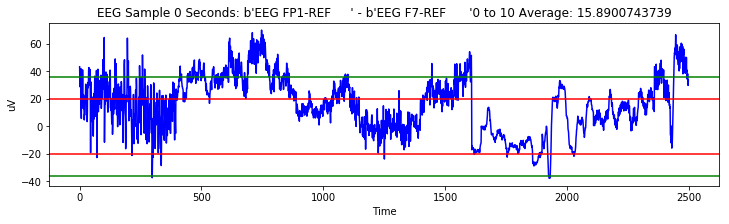

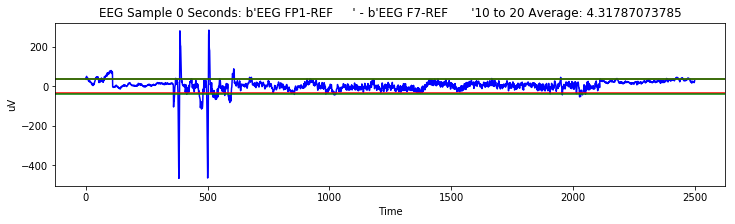

Start index:  2500
End Index:  2750
Peak to Peak range:  92.163078341


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


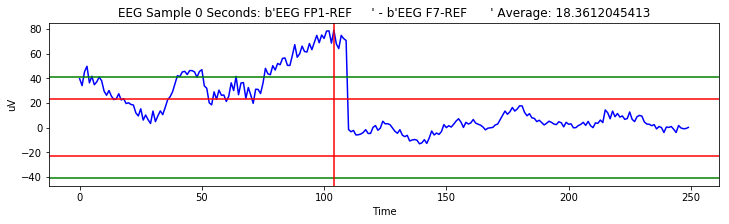

Start index:  2750
End Index:  3000
Peak to Peak range:  744.628844874


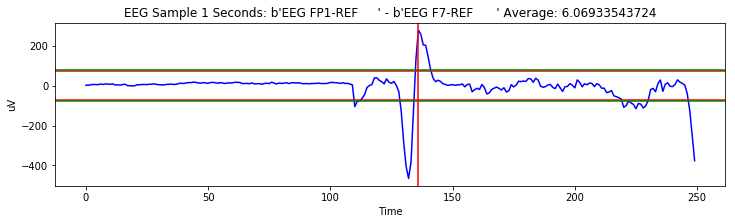

Start index:  3000
End Index:  3250
Peak to Peak range:  746.459899411


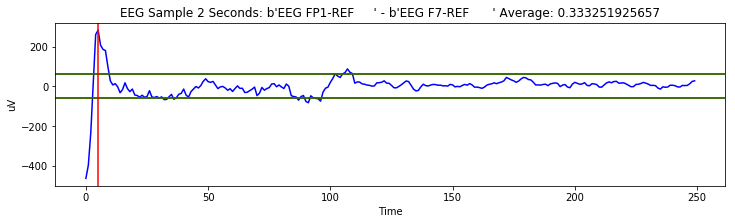

Start index:  3250
End Index:  3500
Peak to Peak range:  78.4301693167


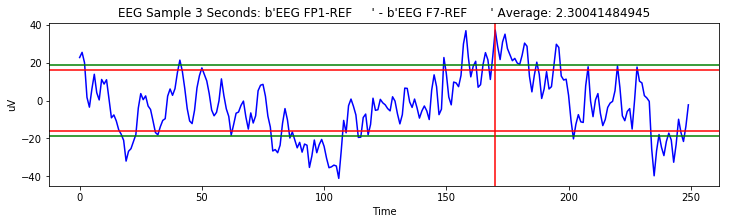

Start index:  3500
End Index:  3750
Peak to Peak range:  76.7517026582


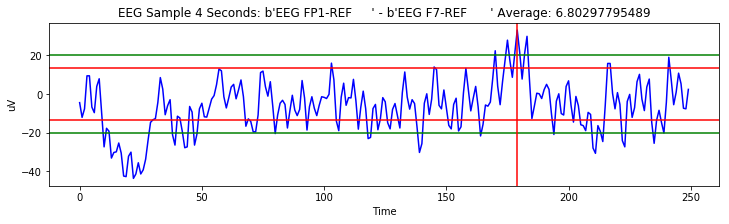

Start index:  3750
End Index:  4000
Peak to Peak range:  71.5637148045


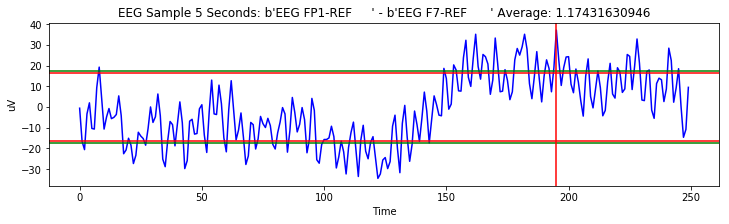

Start index:  4000
End Index:  4250
Peak to Peak range:  67.2912542192


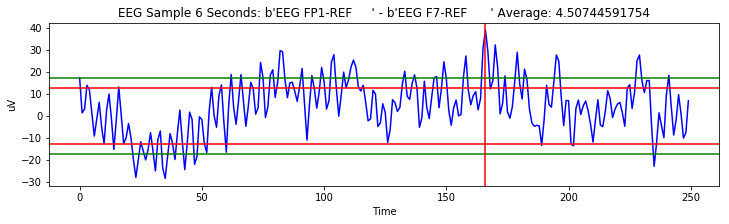

Start index:  4250
End Index:  4500
Peak to Peak range:  88.3483813898


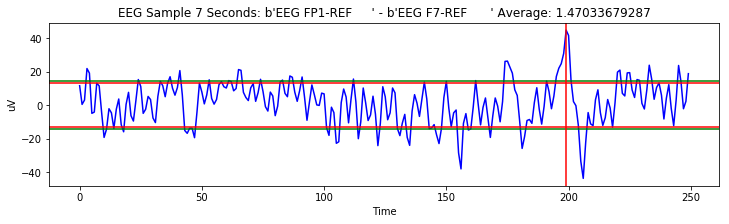

Start index:  4500
End Index:  4750
Peak to Peak range:  92.7734298532


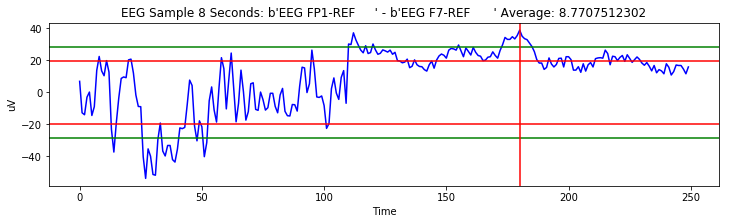

Start index:  4750
End Index:  5000
Peak to Peak range:  37.8417937559


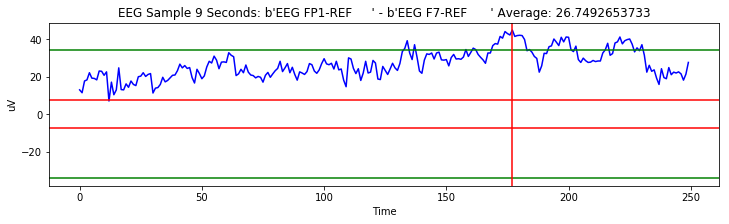

Start index:  5000
End Index:  5250
Peak to Peak range:  92.163078341


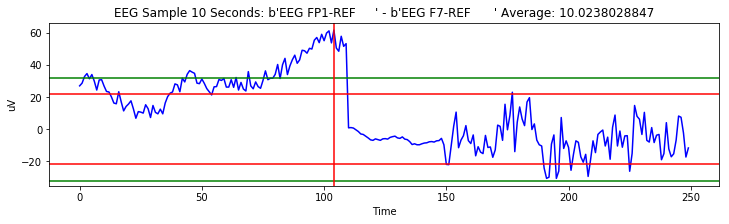

Start index:  5250
End Index:  5500
Peak to Peak range:  67.4438420972


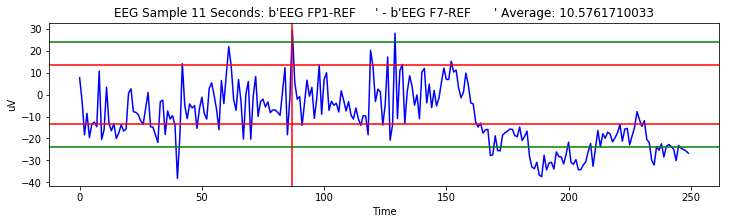

Start index:  5500
End Index:  5750
Peak to Peak range:  83.4655692923


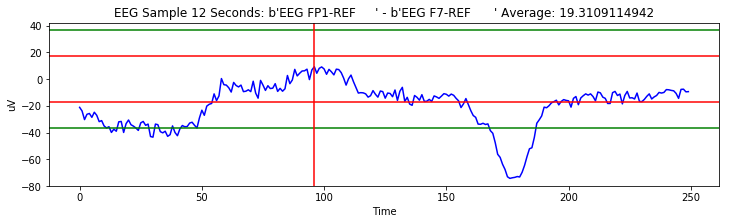

Start index:  5750
End Index:  6000
Peak to Peak range:  53.863520951


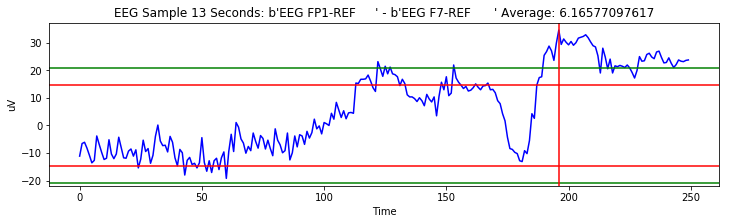

Start index:  6000
End Index:  6250
Peak to Peak range:  28.9916968291


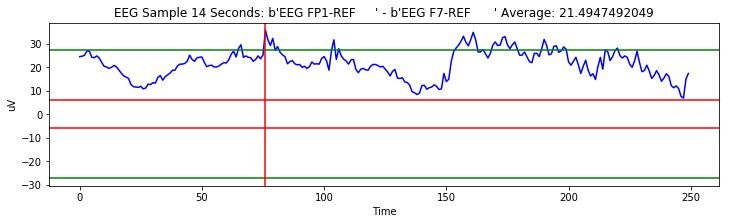

Start index:  6250
End Index:  6500
Peak to Peak range:  48.3703573412


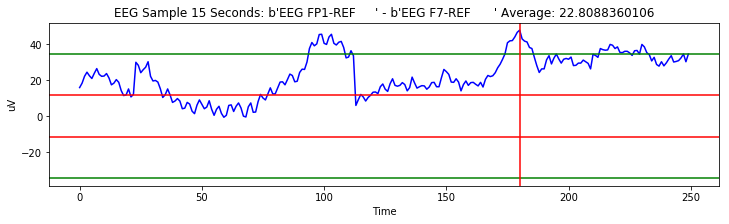

Start index:  6500
End Index:  6750
Peak to Peak range:  60.5773875851


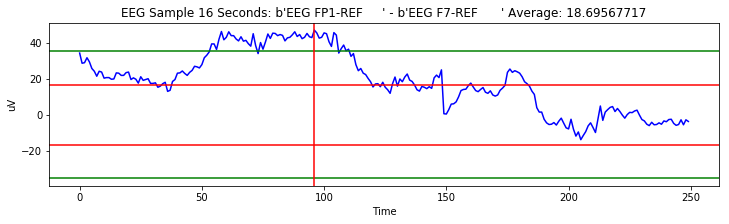

Start index:  6750
End Index:  7000
Peak to Peak range:  804.748468825


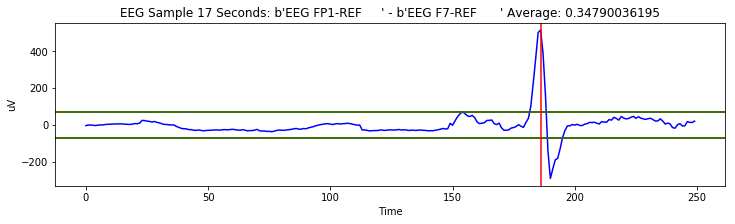

Start index:  7000
End Index:  7250
Peak to Peak range:  795.288020386


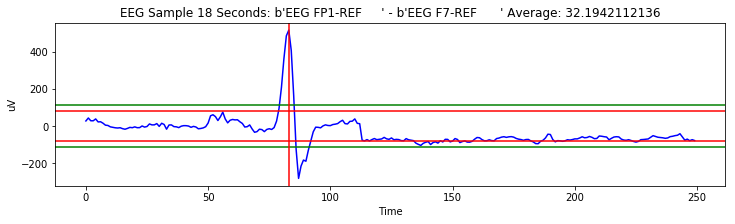

Start index:  7250
End Index:  7500
Peak to Peak range:  170.135484024


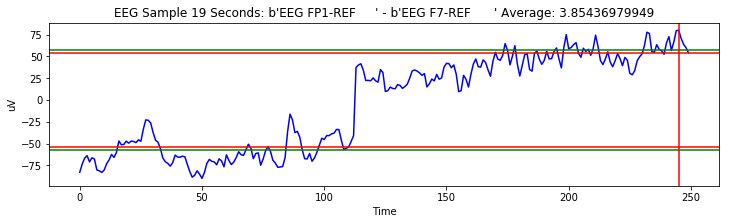

Start index:  7500
End Index:  7750
Peak to Peak range:  101.013175268


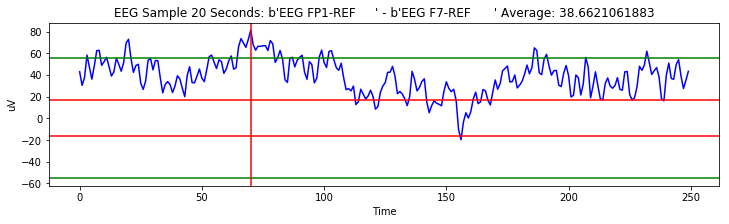

Start index:  7750
End Index:  8000
Peak to Peak range:  71.4111269265


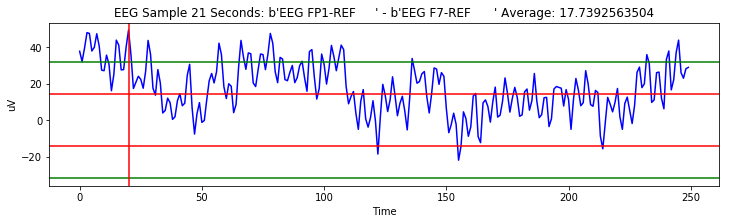

Start index:  8000
End Index:  8250
Peak to Peak range:  98.419181341


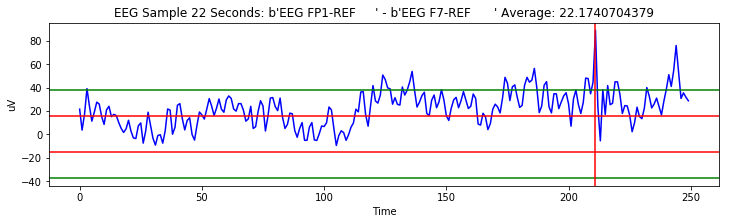

Start index:  8250
End Index:  8500
Peak to Peak range:  87.4328541215


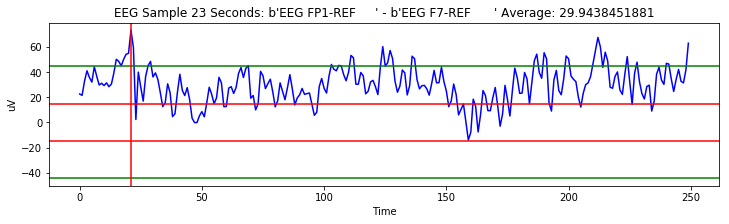

Start index:  8500
End Index:  8750
Peak to Peak range:  62.2558542436


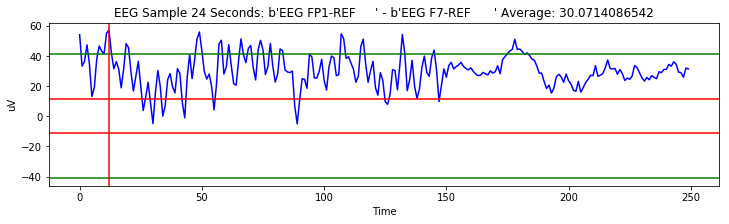

Start index:  8750
End Index:  9000
Peak to Peak range:  61.9506784875


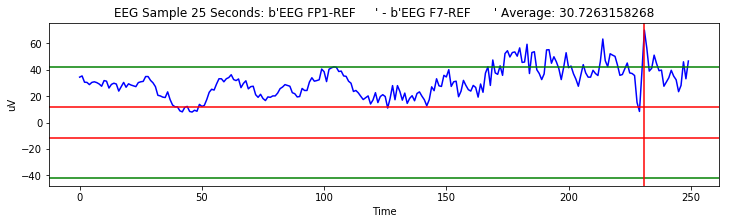

Start index:  9000
End Index:  9250
Peak to Peak range:  65.4601996826


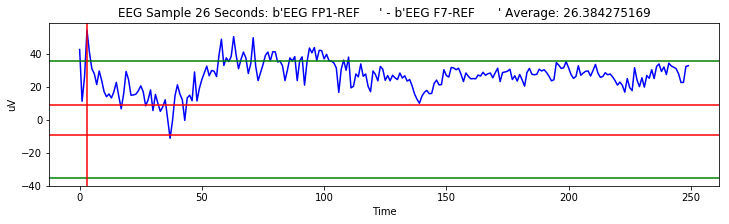

Start index:  9250
End Index:  9500
Peak to Peak range:  72.7844178289


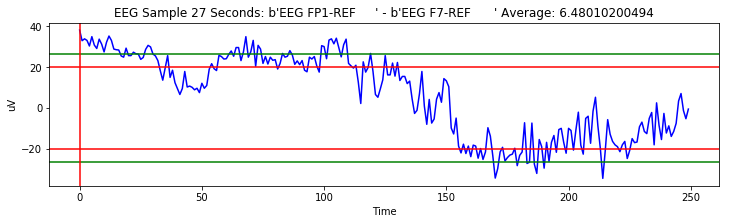

Start index:  9500
End Index:  9750
Peak to Peak range:  110.321035829


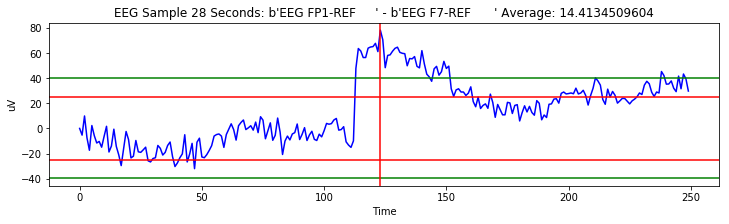

Start index:  9750
End Index:  10000
Peak to Peak range:  74.1577087313


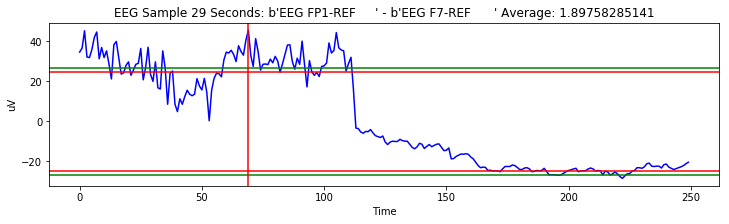

Start index:  10000
End Index:  10250
Peak to Peak range:  58.4411572924


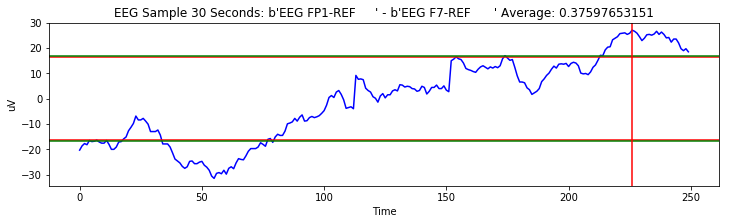

Start index:  10250
End Index:  10500
Peak to Peak range:  26.7028786584


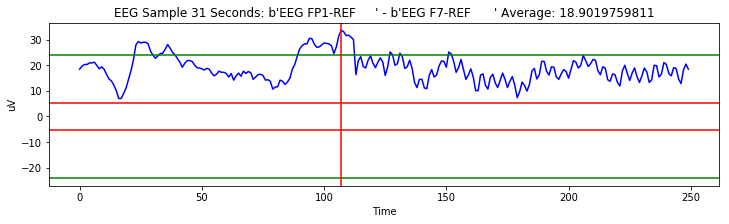

Start index:  10500
End Index:  10750
Peak to Peak range:  74.9206481216


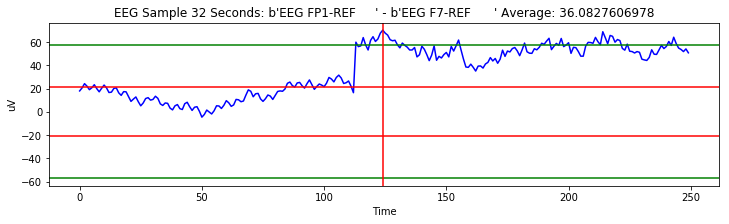

Start index:  10750
End Index:  11000
Peak to Peak range:  99.6398843654


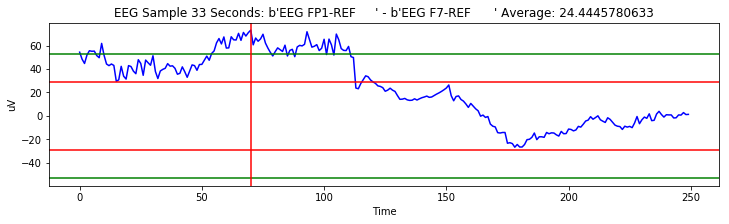

Start index:  11000
End Index:  11250
Peak to Peak range:  759.582456923


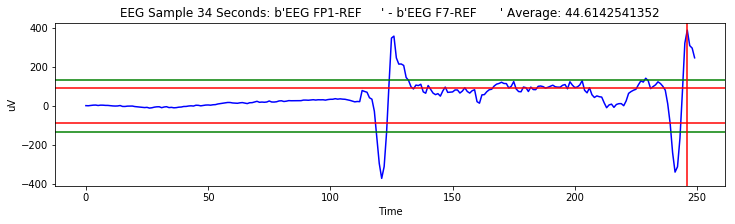

Start index:  11250
End Index:  11500
Peak to Peak range:  577.850294168


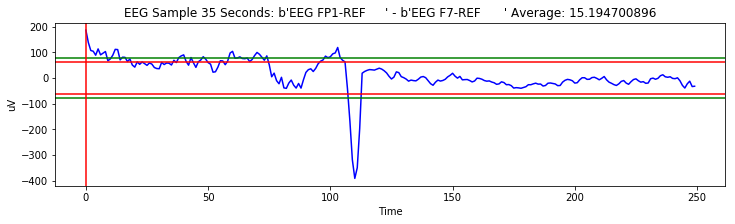

Start index:  11500
End Index:  11750
Peak to Peak range:  83.1603935362


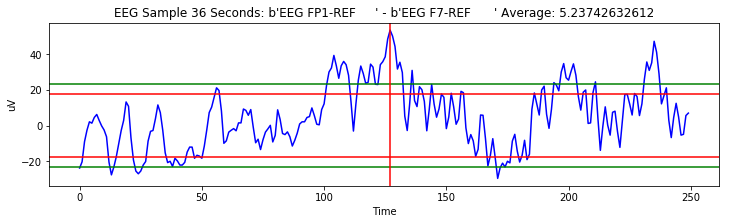

Start index:  11750
End Index:  12000
Peak to Peak range:  93.6889571215


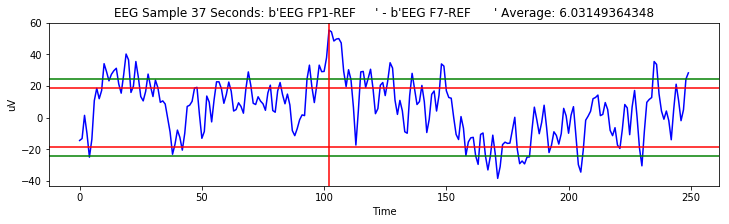

Start index:  12000
End Index:  12250
Peak to Peak range:  73.089593585


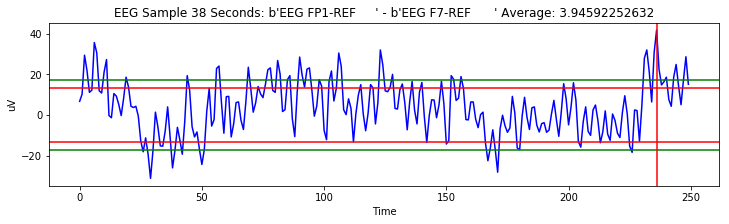

Start index:  12250
End Index:  12500
Peak to Peak range:  76.5991147801


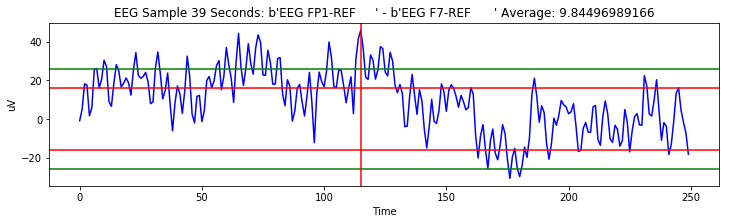

Average Array:  [[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
StdDev Array:  [22.81079961000172, 72.72544668663744, 59.730546621410639, 16.310693654472395, 13.518489400864219, 16.386718763350231, 12.594704020445764, 13.032698064826508, 19.707149245724604, 7.5371053572044069, 21.861538061435109, 13.294605072966601, 17.345841297346198, 14.757090373080411, 5.86436840215549, 11.751796521772532, 16.441130677096719, 71.322045074974653, 80.265796116848762, 53.735232484385712, 16.683539238758087, 14.223042176695488, 15.365532344274293, 14.631386118481622, 11.176274335846621, 11.49637272753599, 9.1494728319388905, 20.096012955550801, 25.3835869342333, 24.921489118888971, 16.328751515657917, 5.299516989945424, 21.21787265891551, 28.672450318438511, 89.7762930962654

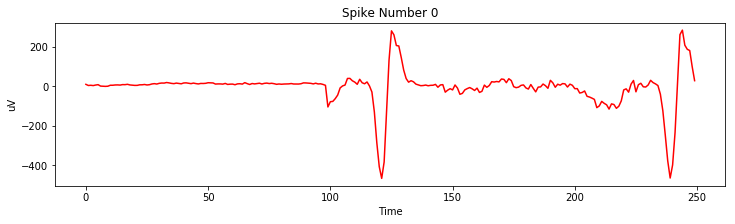

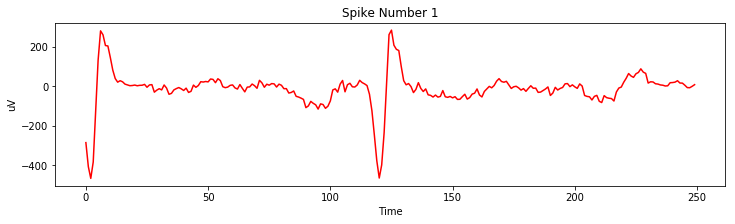

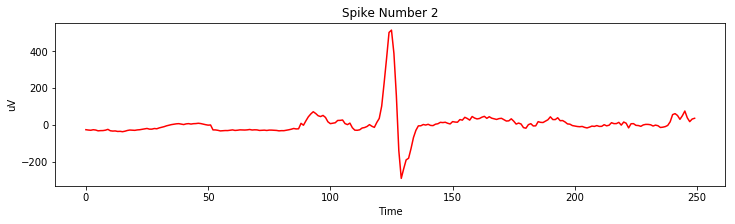

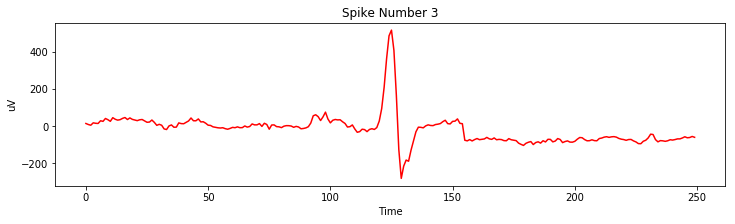

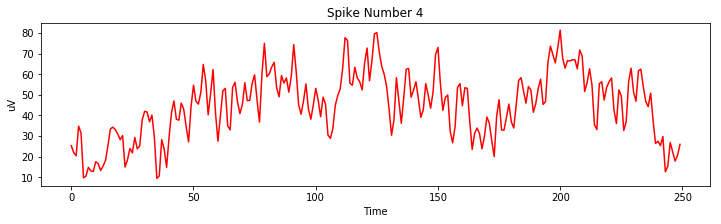

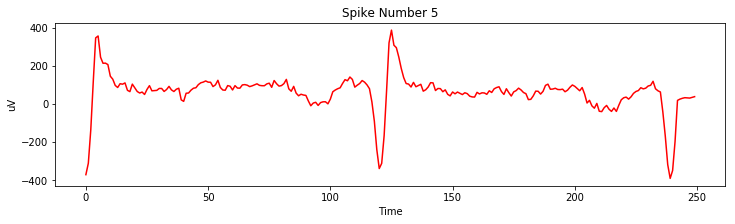

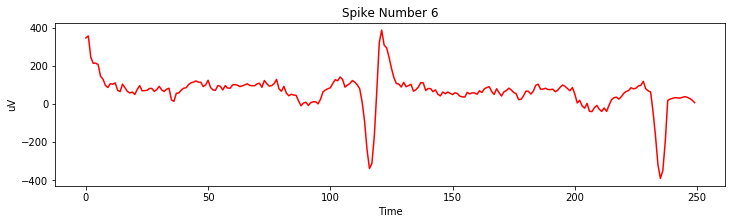

' Don\'t Delete this, it shows the filtered plot with the averages\n    plotThis = channelDataNew[x*10*250:(x+1)*10*250]\n    plotThis = butter_lowpass_filter(normalBackground,40,sampleRate)\n    plotThis = butter_highpass_filter(normalBackground,1,sampleRate)\n    average = np.average(plotThis)\n    plt.xlabel("Time")\n    plt.ylabel("uV")\n    plt.title(("EEG Sample Filter 3hz:35hz Seconds: "+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))\n    plt.plot(plotThis)\n    plt.axhline(y=average, color=\'r\', linestyle=\'-\')\n    plt.axhline(y=(0-average), color=\'r\', linestyle=\'-\')\n    plt.rcParams["figure.figsize"] =(12,3)\n    plt.show()\n    \n'

In [16]:
#ndarray.ptp()  returns the peak to peak distance

print(len(eegChannelData))
print("EEG Keys: ",eegKeys)
#channelDataNew = np.array(testDataFile[eegKeys[channelConstruct[0]]]["data"]) - np.array(testDataFile[eegKeys[channelConstruct[1]]]["data"])



longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8]]

print("testDataFileKeys: ",testDataFile.keys())
testDataFileKeys = list(testDataFile.keys())

channelDataNew = np.array(testDataFile[testDataFileKeys[longBipolarMontage[0][0]]]["data"]) - np.array(testDataFile[testDataFileKeys[longBipolarMontage[0][1]]]["data"])
channelDataNewCh1Label = testDataFileKeys[longBipolarMontage[0][0]]
channelDataNewCh2Label = testDataFileKeys[longBipolarMontage[0][1]]

channelDataFirst = np.array(testDataFile[eegKeys[channelConstruct[0]]]['data'])
print(len(channelDataNew))
print(np.average(channelDataNew))
print(max(channelDataNew))
print(min(channelDataNew))

testDataFileChannel0 = testDataFile[testDataFileKeys[0]]
print("ChannelKeys: ",testDataFileChannel0.keys())
testDataFileChannel0Data = testDataFileChannel0['data']
testDataFileChannel0Label = testDataFileKeys[0]
testDataFileChannel0SampleRate = testDataFileChannel0['sampleRate']
testDataFileChannel0digMax = testDataFileChannel0['digMax']
testDataFileChannel0digMin = testDataFileChannel0['digMin']
testDataFileChannel0physMax = testDataFileChannel0['physMax']
testDataFileChannel0physMin = testDataFileChannel0['physMin']
scaleFactor = testDataFileChannel0physMax/testDataFileChannel0digMax

print('digMin: ',testDataFileChannel0digMin)
print('digMax: ',testDataFileChannel0digMax)
print('physMin: ',testDataFileChannel0physMin)
print('physMax: ',testDataFileChannel0physMax)
print('scale factor: ',scaleFactor)

testDataFileChannel1 = testDataFile[testDataFileKeys[10]]
testDataFileChannel1Data = testDataFileChannel1['data']
testDataFileChannel1Label = testDataFileKeys[10]

testDataFileChannel2 = testDataFile[testDataFileKeys[2]]
testDataFileChannel2Data = testDataFileChannel2['data']
testDataFileChannel2Label = testDataFileKeys[2]

for x in range(2):
    plotThis = channelDataNew[x*10*250:(x+1)*10*250]*scaleFactor
    stdDev = abs(np.std(plotThis))
    average = abs(np.average(plotThis))
    plt.xlabel("Time")
    plt.ylabel("uV")
    plt.title(("EEG Sample 0 Seconds: "+str(channelDataNewCh1Label)+" - "+str(channelDataNewCh2Label)+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))
    plt.plot(plotThis, color='b')
    #plt.plot(testDataFileChannel0Data[x*10*250:(x+1)*10*250], color = 'r')
    #plt.plot(testDataFileChannel1Data[x*10*250:(x+1)*10*250], color = 'b')
    plt.axhline(y=stdDev, color='r', linestyle='-')
    plt.axhline(y=(0-stdDev), color='r', linestyle='-')
    plt.axhline(y=(stdDev+average), color='g', linestyle='-')
    plt.axhline(y=(0-stdDev-average), color='g', linestyle='-')
    plt.rcParams["figure.figsize"] =(12,3)
    plt.show()
    
    
    if x == 1:
        stdDevArray = []
        averageArray = []
        spikeLocationArray = []
        for i in range(40):
            if i==0:
                pass
            startIndex = x*10*250+i*250
            endIndex = x*10*250+i*250+250
            print("Start index: ",startIndex)
            print("End Index: ",endIndex )
            
            plotThisSub = channelDataNew[startIndex:endIndex]*scaleFactor
            peakToPeak = np.ptp(plotThisSub)
            argMax = np.argmax(plotThisSub)
            if peakToPeak > 125:
                spikeLocationArray.append(argMax+startIndex)
                #Need to adjust this to accomodate spikes on the edges of the second being analyzed.
            
            print("Peak to Peak range: ",peakToPeak)

            stdDev = abs(np.std(plotThisSub))
            average = abs(np.average(plotThisSub))
            stdDevArray.append(stdDev)
            averageArray.append(averageArray)
            if i == 4:
                eegNormalSample = plotThisSub
            
            plt.xlabel("Time")
            plt.ylabel("uV")
            plt.title(("EEG Sample "+str(i)+" Seconds: "+str(channelDataNewCh1Label)+" - "+str(channelDataNewCh2Label)+" Average: "+str(average)))
            plt.plot(plotThisSub, color='b')
            plt.axhline(y=stdDev, color='r', linestyle='-')
            plt.axhline(y=(0-stdDev), color='r', linestyle='-')
            plt.axhline(y=(stdDev+average), color='g', linestyle='-')
            plt.axhline(y=(0-stdDev-average), color='g', linestyle='-')
            plt.axes().axvline(argMax,0,1).set_color('red')
            
            plt.show()
            
        
        print("Average Array: ",averageArray)
        print("StdDev Array: ",stdDevArray)
        print("Spike Index Array: ",spikeLocationArray)
        
        for i,spikeLocation in enumerate(spikeLocationArray):
            plotThis = channelDataNew[spikeLocation-125:spikeLocation+125]*scaleFactor
            stdDev = abs(np.std(plotThis))
            average = abs(np.average(plotThis))
            plt.xlabel("Time")
            plt.ylabel("uV")
            plt.title(("Spike Number "+str(i)))
            plt.plot(plotThis, color='r')
            if i==2:
                sampleSpikeData = plotThis
            #plt.plot(testDataFileChannel0Data[x*10*250:(x+1)*10*250], color = 'r')
            #plt.plot(testDataFileChannel1Data[x*10*250:(x+1)*10*250], color = 'b')
            plt.show()
            ### Once this array is completed for each channel the locations can be compared across channels to look for consistency
            ###
            ###
            ###
            ###
            ###
            ### For analysis start at 0 index, move up by 10 or some small number each time, looks for spike indexes, 
            ### Remove ones near edge of current sample, Also remove duplicate indexes. 
            ### Write function to identify upward and downward slope of spike. 
            ### Find morelet wavelet that best fits spikes.
            ### USe these as parameters foor neural network.
    '''
    
    average = np.average(testDataFileChannel0Data[x*10*250:(x+1)*10*250])
    stdDev = np.std(testDataFileChannel0Data[x*10*250:(x+1)*10*250])
    plt.xlabel("Time")
    plt.ylabel("uV")
    plt.title(("EEG Sample 1 Seconds: "+testDataFileChannel0Label+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))
    #plt.plot(plotThis)
    plt.plot(testDataFileChannel0Data[x*10*250:(x+1)*10*250],color ='r')
    #plt.plot(testDataFileChannel1Data[x*10*250:(x+1)*10*250])
    plt.axhline(y=stdDev, color='r', linestyle='-')
    plt.axhline(y=(0-stdDev), color='r', linestyle='-')
    plt.rcParams["figure.figsize"] =(12,3)
    plt.show()
    
    stdDev = np.std(testDataFileChannel1Data[x*10*250:(x+1)*10*250])
    average = np.average(testDataFileChannel1Data[x*10*250:(x+1)*10*250])
    plt.xlabel("Time")
    plt.ylabel("uV")
    plt.title(("EEG Sample 2 Seconds: "+testDataFileChannel1Label+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))
    #plt.plot(plotThis)
    #plt.plot(testDataFileChannel0Data[x*10*250:(x+1)*10*250])
    plt.plot(testDataFileChannel1Data[x*10*250:(x+1)*10*250], color='g')
    plt.axhline(y=stdDev, color='r', linestyle='-')
    plt.axhline(y=(0-stdDev), color='r', linestyle='-')
    plt.rcParams["figure.figsize"] =(12,3)
    plt.show()
    
    stdDev = np.std(testDataFileChannel2Data[x*10*250:(x+1)*10*250])
    average = np.average(testDataFileChannel2Data[x*10*250:(x+1)*10*250])
    plt.xlabel("Time")
    plt.ylabel("uV")
    plt.title(("EEG Sample 2 Seconds: "+testDataFileChannel2Label+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))
    #plt.plot(plotThis)
    #plt.plot(testDataFileChannel0Data[x*10*250:(x+1)*10*250])
    plt.plot(testDataFileChannel2Data[x*10*250:(x+1)*10*250], color='m')
    plt.axhline(y=average, color='r', linestyle='-')
    plt.axhline(y=(0-average), color='r', linestyle='-')
    plt.rcParams["figure.figsize"] =(12,3)
    plt.show()
'''
''' Don't Delete this, it shows the filtered plot with the averages
    plotThis = channelDataNew[x*10*250:(x+1)*10*250]
    plotThis = butter_lowpass_filter(normalBackground,40,sampleRate)
    plotThis = butter_highpass_filter(normalBackground,1,sampleRate)
    average = np.average(plotThis)
    plt.xlabel("Time")
    plt.ylabel("uV")
    plt.title(("EEG Sample Filter 3hz:35hz Seconds: "+str(x*10)+" to "+str((x+1)*10)+" Average: "+str(average)))
    plt.plot(plotThis)
    plt.axhline(y=average, color='r', linestyle='-')
    plt.axhline(y=(0-average), color='r', linestyle='-')
    plt.rcParams["figure.figsize"] =(12,3)
    plt.show()
    
'''
    

Data Length:  386736
[2860, 2882, 3000, 6936, 7083, 7137, 11121, 11246, 11360, 15230, 15379, 19368, 19481, 19601, 23518, 23525, 23646, 23651, 27249, 27251, 27653, 27723, 27843, 27850, 31661, 31803, 35942, 35965, 36087, 39947, 40089, 44182, 44210, 44329, 44364, 46849, 46873, 46876, 47127, 48220, 48233, 48374, 48375, 49620, 49770, 49778, 52098, 52121, 52127, 52349, 52372, 52377, 52423, 52426, 52452, 52571, 52576, 52622, 54145, 54151, 54202, 54896, 54912, 54943, 54952, 55131, 55156, 55175, 55200, 55237, 55338, 56516, 56655, 56788, 57647, 57675, 60143, 60392, 60400, 60428, 60699, 60700, 60817, 60825, 62636, 63348, 63369, 63376, 63629, 64799, 64800, 65917, 68619, 68630, 68849, 68874, 68881, 68943, 69074, 69076, 69110, 69125, 71397, 71402, 71428, 71642, 71653, 72948, 73089, 76639, 76899, 76905, 76925, 77195, 77319, 77325, 79695, 81234, 81374, 81375, 84947, 84973, 84975, 85016, 85131, 85318, 85446, 85571, 85575, 89517, 89659, 93144, 93183, 93349, 93350, 93402, 93669, 93698, 93824, 93825, 9632

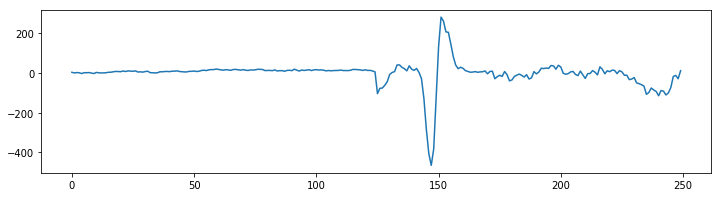

0


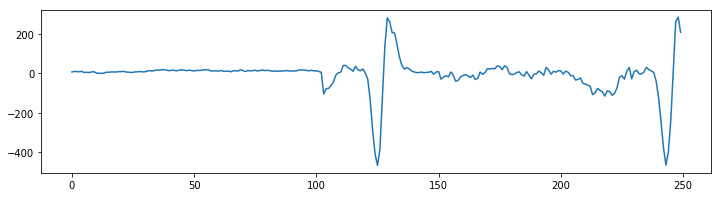

1


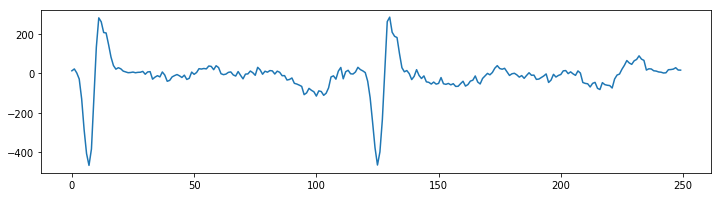

1


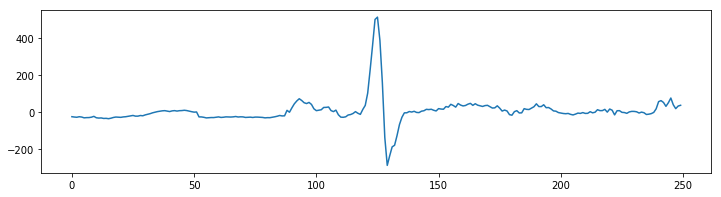

1


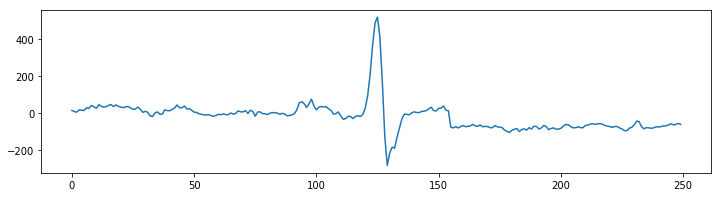

1


In [38]:
def lookForSpikes(data,sampleRate,stepSize,searchSize,ampThreshold,ptpThreshold):
    '''
    data should already be scaled
    stepSize in samples
    searchSize in seconds
    returns: array of possible spike indices
    '''
    dataLength = len(data)
    print("Data Length: ",dataLength)
    searchSamples = searchSize * sampleRate
    searchNumber = dataLength/stepSize
    endSampleLag = searchSamples/stepSize
    possibleSpikeArray = []
    for x in range(int(searchNumber)-int(endSampleLag)):
        #print(x)
        startIndex = x*stepSize
        endIndex = x*stepSize+searchSamples
        #print("start index: ",startIndex)
        #print("end index: ",endIndex)
        currentData = data[int(startIndex):int(endIndex)]
        currentMax = np.amax(np.absolute(currentData))
        if currentMax>ampThreshold:
            #print("Found a max!")
            try:
                maxIndex = list(currentData).index(currentMax)
                #print("In Try")
            except:
                maxIndex = list(currentData).index(0-currentMax)
                #print("Int EXcept")
            maxIndex = maxIndex + startIndex
            if maxIndex not in possibleSpikeArray:
                #print("Adding maxIndex")
                possibleSpikeArray.append(maxIndex)
                
    return possibleSpikeArray
   

testData = np.array(testDataFile[testDataFileKeys[longBipolarMontage[0][0]]]["data"]) - np.array(testDataFile[testDataFileKeys[longBipolarMontage[0][1]]]["data"])
testData = testData*scaleFactor
possibleSpikeIndex = lookForSpikes(testData,250,25,1,100,125)
print(possibleSpikeIndex)
            
trainingArray = []

def checkInput():
    a = input()
    a = int(a)
    if a!=0 or a!=1:
        checkInput()
    return a

#0 = no spike
#1 = spike
for x in possibleSpikeIndex[0:5]:
    plt.plot(testData[x-125:x+125])
    plt.show()
    a = input()
    trainingArray.append([x,a])

#sampleTxtFile = 'fnszDirectory/'+str(featureFiles[0])
trainingFileName = "training_fnsz_"+str(featureFiles[0])
with open(trainingFileName,'w') as trainingDataFile:
    trainingDataFile.write(str(trainingArray))
            
#a = input()
#print(a)

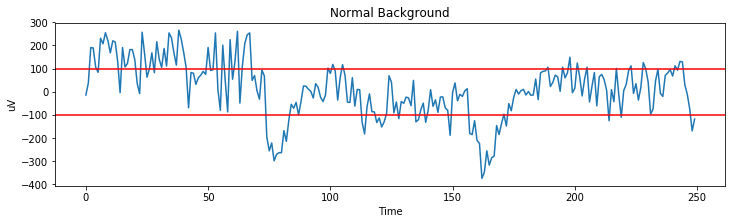

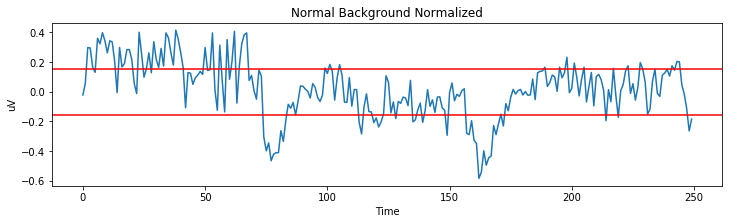

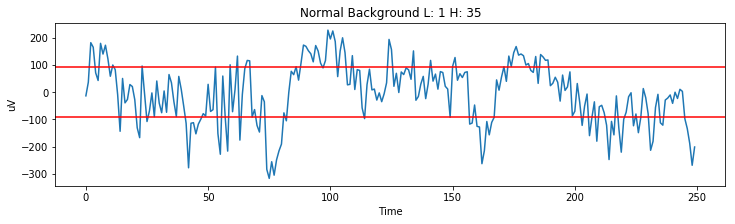

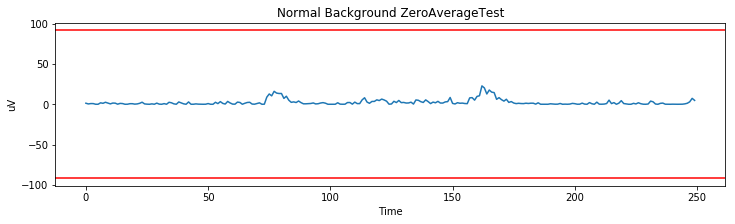

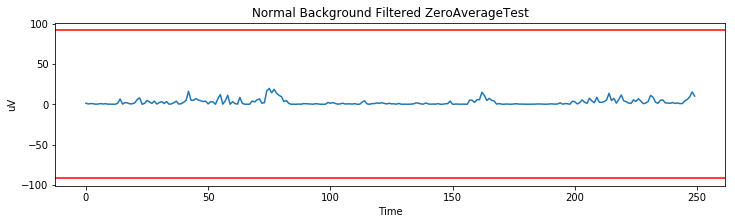

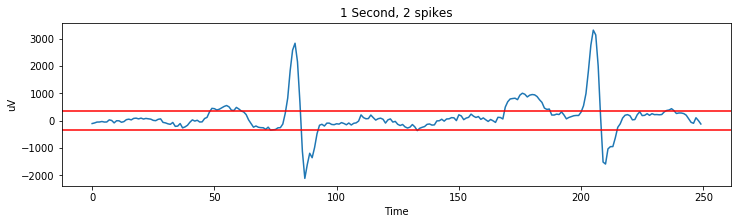

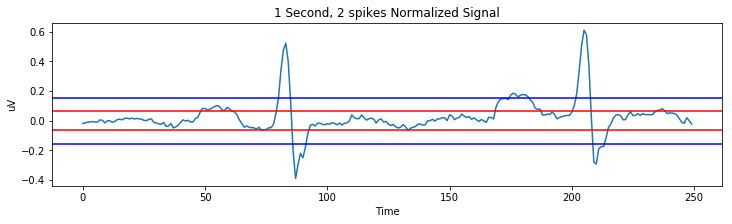

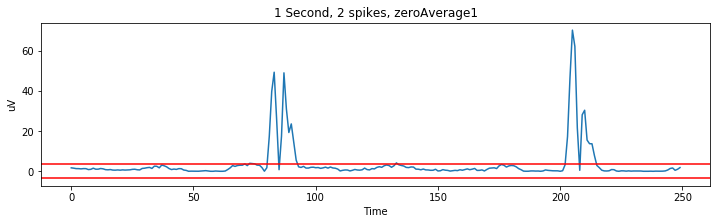

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


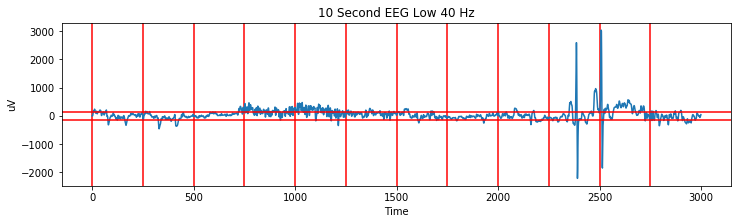

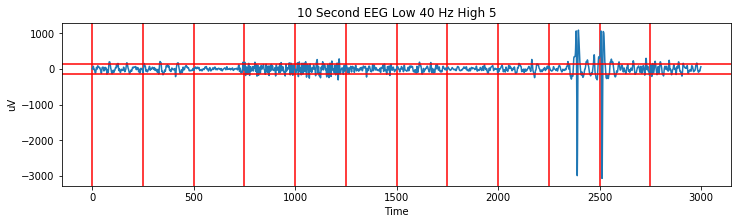

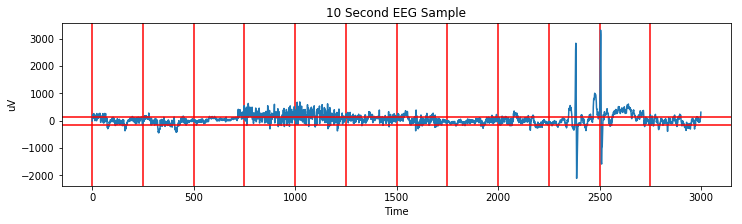

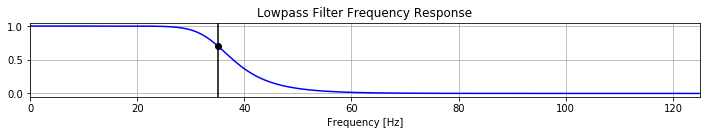

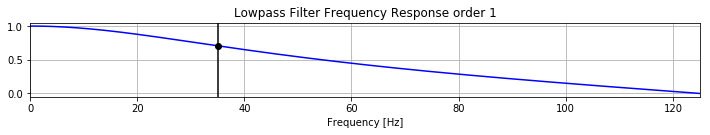

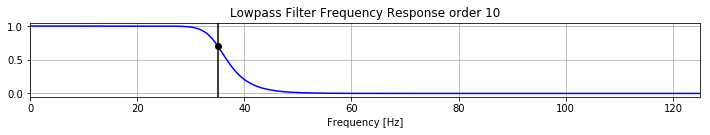

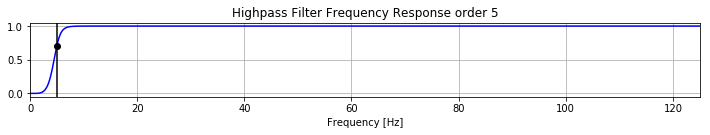

In [36]:
#https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff,btype='high', analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order = 5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def range_filter(data, low, high, fs, order = 5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    

def zeroAverage1(data):
    average = np.mean(np.absolute(data))
    returnData = []
    for x in data:
        returnData.append(((x-average)/average)**2)
    return returnData

def normalizeSignal(data):
    maxValue = max(data)
    minValue = min(data)
    valueRange = maxValue-minValue
    returnArray = []
    for x in data:
        returnArray.append(x/valueRange)
    return returnArray
        


# Filter requirements.
order = 6
fs = 250       # sample rate, Hz
cutoff = 35  # desired cutoff frequency of the filter, Hz

#def getAvgHiLo
eegExample10Seconds = eegChannelData[0:3000]
eegExample10SecondsLow40Order5 = butter_lowpass_filter(eegExample10Seconds,40,sampleRate)
eegExample10SecondsLow40High5Order5 = butter_highpass_filter(eegExample10SecondsLow40Order5,5,sampleRate)

oneSecondAverage = np.average(np.absolute(normalBackground))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("Normal Background")
plt.plot(normalBackground)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

normalizeNormal = normalizeSignal(normalBackground)
oneSecondAverageNormal = np.average(np.absolute(normalizeNormal))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("Normal Background Normalized")
plt.plot(normalizeNormal)
plt.axhline(y=oneSecondAverageNormal, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverageNormal), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

eegNormalLow40Order5 = butter_lowpass_filter(normalBackground,35,sampleRate)
eegNormalLow40High5Order5 = butter_highpass_filter(normalBackground,1,sampleRate)
oneSecondAverage = np.average(np.absolute(eegNormalLow40High5Order5))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("Normal Background L: 1 H: 35")
plt.plot(eegNormalLow40High5Order5)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

zeroAverageTest = zeroAverage1(normalBackground)
zeroAverage = np.average(np.absolute(normalBackground))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("Normal Background ZeroAverageTest")
plt.plot(zeroAverageTest)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

eegNormalLow40Order5 = butter_lowpass_filter(normalBackground,35,sampleRate)
eegNormalLow40High5Order5 = butter_highpass_filter(normalBackground,1,sampleRate)
zeroAverageTest = zeroAverage1(eegNormalLow40High5Order5)
zeroAverage = np.average(np.absolute(normalBackground))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("Normal Background Filtered ZeroAverageTest")
plt.plot(zeroAverageTest)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

oneSecondAverage = np.average(np.absolute(spikeSample2))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("1 Second, 2 spikes")
plt.plot(spikeSample2)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

normalizeSpikes = normalizeSignal(spikeSample2)
oneSecondAverage = np.average(np.absolute(normalizeSpikes))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("1 Second, 2 spikes Normalized Signal")
plt.plot(normalizeSpikes)
plt.axhline(y=oneSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-oneSecondAverage), color='r', linestyle='-')
plt.axhline(y=oneSecondAverageNormal, color='b', linestyle='-')
plt.axhline(y=(0-oneSecondAverageNormal), color='b', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

zeroAverageTest = zeroAverage1(spikeSample2)
zeroAverage = np.average(np.absolute(zeroAverageTest))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("1 Second, 2 spikes, zeroAverage1")
plt.plot(zeroAverageTest)
plt.axhline(y=zeroAverage, color='r', linestyle='-')
plt.axhline(y=(0-zeroAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsLow40Order5))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Low 40 Hz")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsLow40Order5)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondChangeAverage = np.average(np.absolute(eegExample10SecondsLow40High5Order5))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Low 40 Hz High 5")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10SecondsLow40High5Order5)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()

tenSecondAverage = np.average(np.absolute(eegExample10Seconds))
plt.xlabel("Time")
plt.ylabel("uV")
plt.title("10 Second EEG Sample")
for x in range(0,12):
    plt.axes().axvline(x*sampleRate,0,1).set_color('red')
plt.plot(eegExample10Seconds)
plt.axhline(y=tenSecondAverage, color='r', linestyle='-')
plt.axhline(y=(0-tenSecondAverage), color='r', linestyle='-')
plt.rcParams["figure.figsize"] =(12,3)
plt.show()


# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

b, a = butter_lowpass(cutoff, fs, 1)
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response order 1")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

b, a = butter_lowpass(cutoff, fs, 10)
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response order 10")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

highcutoff = 5
b, a = butter_highpass(highcutoff, fs, 5)
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(highcutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(highcutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Highpass Filter Frequency Response order 5")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()



In [23]:
fftLength = len(fftExample2)
print("Size: ",fftLength)
print("Max: ",max(fftExample2))
print("Max Index: ",list(fftExample2).index(max(fftExample2)))
print("MinL ",min(fftExample2))
print(fftExample2)

Size:  250
Max:  (10967.7837231+0j)
Max Index:  0
MinL  (-1278.253216-4806.48366657j)
[  1.09677837e+04 +0.00000000e+00j  -1.04877373e+03 +2.92748687e+03j
  -1.27825322e+03 +4.80648367e+03j   1.92497078e+03 +1.48684417e+03j
   3.72646474e+02 +2.08394604e+03j   3.84003520e+02 +2.48797374e+03j
  -6.07156452e+00 -5.94704700e+02j  -7.48439593e+01 +1.51469681e+03j
   1.75745558e+01 -6.62518187e+01j   3.71640972e+02 +6.83505232e+02j
   2.67123108e+02 +8.84736260e+02j   2.08610599e+02 +3.41446028e+02j
   4.28489973e+02 +2.06824528e+02j  -2.19359366e+02 -1.35599502e+02j
   3.74401613e+01 +6.56421667e+02j  -6.68456723e+01 +1.90073740e+02j
  -2.05133030e+02 +2.42033479e+02j   2.09529474e+02 -2.77936518e+01j
   1.46698912e+02 +2.42384408e+02j   1.76431198e+02 -4.83201959e+01j
  -5.37494749e+01 +1.77281334e+02j   2.00199278e+02 +1.39564721e+02j
  -1.15016223e+02 +1.93289162e+02j  -1.14388085e+02 +8.59128981e+01j
   3.23610043e+01 +1.18842588e+02j  -1.35221356e+02 +1.59098633e+02j
   1.64297566e+02

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


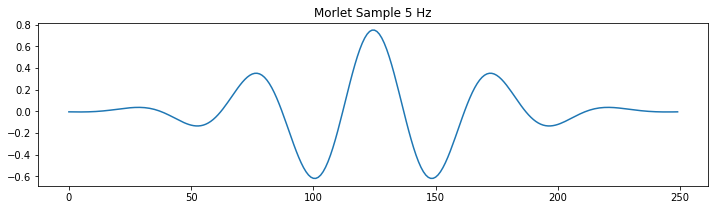

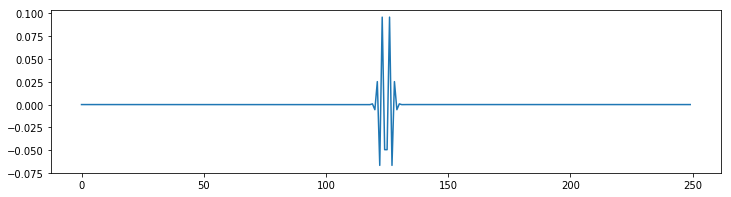

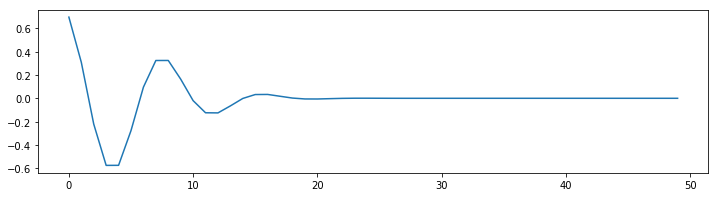

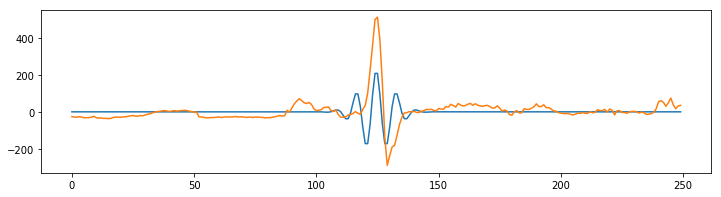

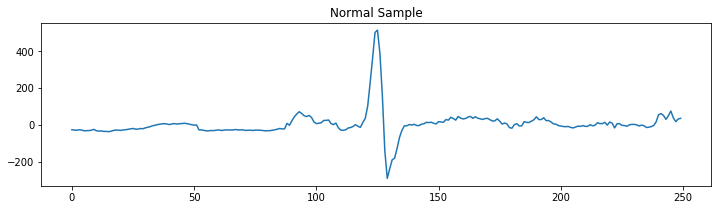

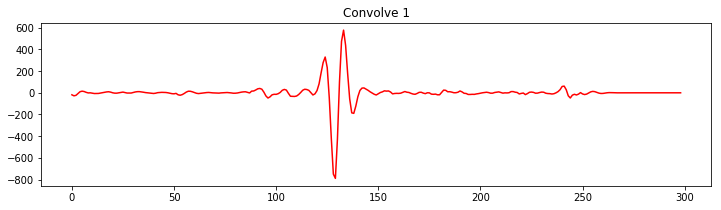

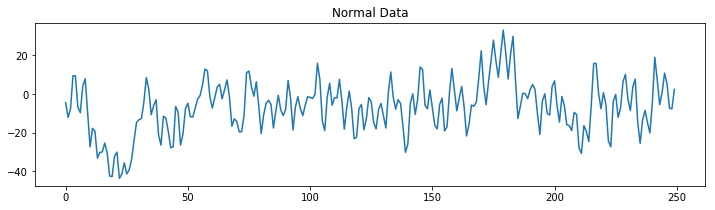

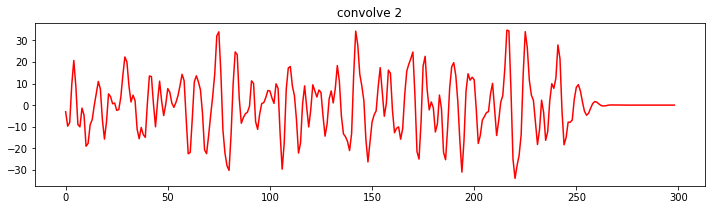

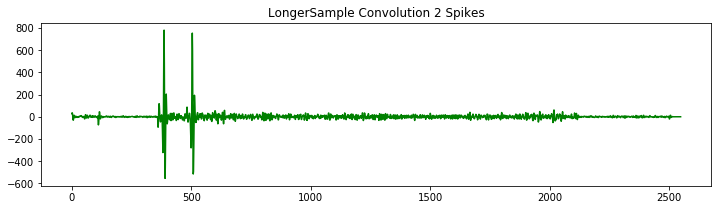

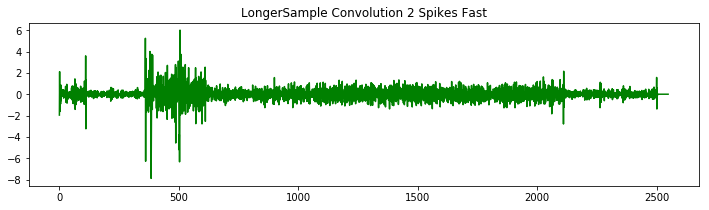

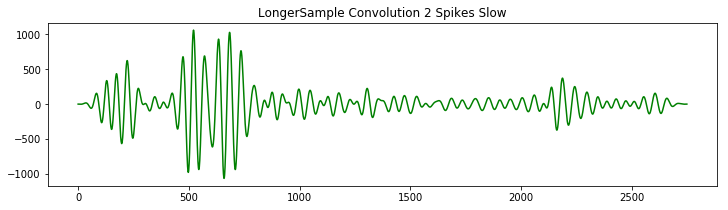

In [66]:
morletSampleSlow = scipy.signal.morlet(250, w=5.0, s=0.5, complete=True)
plt.title("Morlet Sample 5 Hz")
plt.plot(morletSampleSlow)
plt.show()

#This wavelet looks like a spike
morletSampleFast = scipy.signal.morlet(250, w=5.0, s=13, complete=True)
morletSampleFastShortened = morletSampleFast[125:175]
plt.plot(morletSampleFast)
plt.show()

morletSample = scipy.signal.morlet(250, w=5.0, s=3.0, complete=True)
morletSampleShortened = morletSample[125:175]


plt.plot(morletSampleShortened)
plt.show()

plt.plot(morletSample*300)
plt.plot(sampleSpikeData) 
plt.show()

#sampleSpikeData contains a 1 second sample containing a spike

plt.plot(sampleSpikeData)
plt.title("Normal Sample")
plt.show()

convolve1 = np.convolve(sampleSpikeData,morletSampleShortened)
plt.title("Convolve 1")
plt.plot(convolve1, color='r')
plt.show()

plt.plot(eegNormalSample)
plt.title("Normal Data")
plt.show()

convolve2 = np.convolve(eegNormalSample,morletSampleShortened)
plt.title("convolve 2")
plt.plot(convolve2,color='r')
plt.show()

longerSample = channelDataNew[2500:5000]*scaleFactor
convolve3 = np.convolve(longerSample,morletSampleShortened)
plt.title("LongerSample Convolution 2 Spikes")
plt.plot(convolve3,color='g')
plt.show()

convolve4 = np.convolve(longerSample,morletSampleFastShortened)
plt.title("LongerSample Convolution 2 Spikes Fast")
plt.plot(convolve4,color='g')
plt.show()

convolve5 = np.convolve(longerSample,morletSampleSlow)
plt.title("LongerSample Convolution 2 Spikes Slow")
plt.plot(convolve5,color='g')
plt.show()

In [67]:
a = input()
print(a)

asfasdfsd
asfasdfsd
